## !!!IMPORTANT!!!
### To avoid exceptions, please make sure data files 'price.csv', 'sp.csv', 'advs.csv' are in the same directory with this .ipynb file before running. Do not change the name of these data files.

In [38]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import pandas_datareader as web
from scipy.stats import norm

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

%matplotlib inline

# IV. Portfolio Optimization

## 1) CAPM and Covariance Matrix

### Get historical cumulative return of ~500 stocks and SP500; market premium, and risk free rate

In [39]:
# Get historical cumulative return of ~500 stocks and SP500
stocks = pd.read_csv('price.csv')
sprf = pd.read_csv('sp.csv')
df = stocks.merge(sprf, on = 'Date')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.drop('Rf', axis = 1)
df = df.iloc[::-1]
ret = np.log((df/df.shift(1)))
ret = ret.dropna()
ret.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SP500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.013036,0.008602,0.008173,-0.001120,0.014002,0.024512,0.029638,0.007907,0.002401,0.006358,...,-0.011063,0.008155,0.037041,0.014794,0.003632,0.009152,0.009003,0.014256,0.009657,0.005706
2017-01-05,-0.011961,-0.017497,-0.000698,0.005072,0.007556,-0.011643,-0.008068,0.008601,-0.015104,0.016854,...,-0.015019,-0.013114,-0.004205,-0.009171,0.003305,0.006404,-0.026547,-0.016343,-0.003332,-0.000771
2017-01-06,0.030680,0.006949,-0.013177,0.011087,0.000314,0.013296,0.005299,0.026841,0.011328,0.022315,...,-0.000565,-0.000686,-0.015570,-0.007034,0.012025,0.000095,0.014176,0.006477,0.003147,0.003511
2017-01-09,0.003121,0.018652,-0.000590,0.009118,0.006563,0.007987,0.014536,-0.000981,-0.011241,0.002490,...,-0.016635,0.003083,-0.005722,-0.004245,0.002790,0.019250,0.000116,-0.010896,-0.002776,-0.003555
2017-01-10,-0.000831,0.029303,0.002298,0.001008,-0.002183,-0.007633,-0.042474,0.013410,0.000522,-0.002859,...,-0.012835,-0.005144,0.008571,-0.004670,0.005865,0.060471,-0.006184,0.015267,-0.000371,0.000000


In [3]:
# Get historical cumulative risk free rate and market premium
sprf['Date'] = pd.to_datetime(sprf['Date'])
sprf = sprf.set_index('Date')
sprf = sprf.dropna()
rf = np.log(1+sprf['Rf']/100/365)
rf = rf[::-1]
mkt_prem = ret['SP500'] - rf
mkt_prem

Date
2017-01-03         NaN
2017-01-04    0.005691
2017-01-05   -0.000785
2017-01-06    0.003497
2017-01-09   -0.003569
                ...   
2019-12-24   -0.000239
2019-12-26    0.005072
2019-12-27   -0.000009
2019-12-30   -0.005840
2019-12-31    0.002899
Length: 750, dtype: float64

### Run regression model on each of the 500 stocks

In [4]:
# Run regression of stocks on market, get betas and alphas

import statsmodels.api as sm
tickers = []
betas = []
alphas = []
beta_tstats = []
alpha_tstats = []
r2 = []
for i in range(len(ret.columns)-1):
    i_prem = pd.DataFrame((ret.iloc[:,i] - rf), columns = {ret.columns[i]})
    i_prem['const'] = 1
    i_prem['mkt_prem'] = mkt_prem
    
    reg = sm.OLS(endog = i_prem[ret.columns[i]], exog = i_prem[['mkt_prem', 'const']], missing = "drop")
    result = reg.fit()
    beta = result.params.mkt_prem
    alpha = result.params.const
    beta_t = result.tvalues.mkt_prem
    alpha_t = result.tvalues.const
    ticker = ret.columns[i]
    
    tickers.append(ticker)
    betas.append(beta)
    alphas.append(alpha)
    beta_tstats.append(beta_t)
    alpha_tstats.append(alpha_t)

In [5]:
len(betas) == len(alphas) == len(tickers) == len(beta_tstats) == len(alpha_tstats)

True

### Get current covariance matrix

In [6]:
cov = ret.drop('SP500', axis = 1).cov()
cov

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.000217,0.000112,0.000044,0.000099,0.000089,0.000066,0.000137,0.000101,0.000090,0.000130,...,0.000117,0.000059,0.000061,0.000082,0.000095,0.000054,0.000084,0.000118,0.000081,0.000092
AAL,0.000112,0.000498,0.000086,0.000125,0.000077,0.000098,0.000101,0.000088,0.000083,0.000135,...,0.000192,0.000060,0.000067,0.000134,0.000120,0.000054,0.000083,0.000166,0.000129,0.000090
AAP,0.000044,0.000086,0.000439,0.000038,0.000053,0.000068,0.000042,0.000044,0.000050,0.000038,...,0.000050,0.000044,0.000036,0.000068,0.000047,0.000028,0.000043,0.000049,0.000080,0.000050
AAPL,0.000099,0.000125,0.000038,0.000246,0.000077,0.000062,0.000157,0.000088,0.000092,0.000147,...,0.000155,0.000068,0.000057,0.000086,0.000083,0.000047,0.000075,0.000134,0.000076,0.000079
ABBV,0.000089,0.000077,0.000053,0.000077,0.000314,0.000082,0.000116,0.000093,0.000077,0.000101,...,0.000085,0.000058,0.000072,0.000065,0.000072,0.000039,0.000077,0.000083,0.000071,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.000054,0.000054,0.000028,0.000047,0.000039,0.000031,0.000046,0.000051,0.000049,0.000072,...,0.000060,0.000030,0.000020,0.000051,0.000048,0.000109,0.000038,0.000054,0.000034,0.000061
ZBH,0.000084,0.000083,0.000043,0.000075,0.000077,0.000076,0.000102,0.000088,0.000068,0.000092,...,0.000076,0.000045,0.000067,0.000072,0.000063,0.000038,0.000187,0.000075,0.000063,0.000063
ZBRA,0.000118,0.000166,0.000049,0.000134,0.000083,0.000073,0.000191,0.000091,0.000092,0.000154,...,0.000174,0.000076,0.000005,0.000143,0.000116,0.000054,0.000075,0.000475,0.000098,0.000100
ZION,0.000081,0.000129,0.000080,0.000076,0.000071,0.000059,0.000105,0.000059,0.000064,0.000067,...,0.000108,0.000066,0.000048,0.000100,0.000083,0.000034,0.000063,0.000098,0.000237,0.000050


### Set up selected stock range 
### Get betas, alphas, t-stats and 1-day SeY for each selected stock

In [7]:
sel = range(50,100)

beta_sel = []
alpha_sel = []
tick_sel = []
beta_tstats_sel = []
alpha_tstats_sel = []
for i in sel:
    beta_sel.append(betas[i])
    alpha_sel.append(alphas[i])
    tick_sel.append(tickers[i])
    beta_tstats_sel.append(beta_tstats[i])
    alpha_tstats_sel.append(alpha_tstats[i])

SeY_sel = []
for i in range(len(tick_sel)):
    tick = tick_sel[i]
    y_est = beta_sel[i] * mkt_prem + alpha_sel[i] 
    y_est_error = y_est-ret[tick]
    std_est = y_est_error.std()
    SeY_sel.append(std_est)
    
capm_df = pd.DataFrame({'Stock':list(sel),
                       'Symbol':tick_sel,
                       'Alpha':alpha_sel,
                       't-stat_alpha':alpha_tstats_sel,
                       'Beta':beta_sel,
                       't-stat_beta':beta_tstats_sel,
                       '1-day_SeY':SeY_sel})
capm_df

,Stock,Symbol,Alpha,t-stat_alpha,Beta,t-stat_beta,1-day_SeY
0,50,ATVI,0.000001,0.001689,1.383443,16.207105,0.018908
1,51,AVB,-0.000001,-0.004241,0.427472,10.451275,0.009061
2,52,AVGO,0.000170,0.287907,1.267846,17.465440,0.016080
3,53,AVY,0.000375,0.964821,0.950401,19.818743,0.010622
4,54,AWK,0.000550,1.543589,0.260661,5.930518,0.009737
5,55,AXP,0.000164,0.559204,1.064680,29.455775,0.008007
6,56,AZO,0.000280,0.493565,0.509102,7.278414,0.015496
7,57,BA,0.000417,0.816771,1.184295,18.832339,0.013930
8,58,BAC,0.000022,0.054876,1.222722,25.084949,0.010797
9,59,BAX,0.000413,1.133543,0.890943,19.844830,0.009945


In [8]:
# Test

# i = 300

# i_prem = pd.DataFrame((ret.iloc[:,i] - rf), columns = {ret.columns[i]})
# i_prem['const'] = 1
# i_prem['mkt_prem'] = mkt_prem

# reg = sm.OLS(endog = i_prem[ret.columns[i]], exog = i_prem[['mkt_prem', 'const']], missing = "drop")
# print(reg.fit().summary())

### Set up Market Senarios and estimated covariance matrix

In [9]:
mkt_e = 0.0910
mkt_v = 0.02467
mkt_rf = 0.02

rangenum = range(len(sel))
covmx_array = np.ones((len(sel),len(sel)))
for i in rangenum:
    for j in rangenum:
        covmx_array[i][j] = beta_sel[i]*beta_sel[j]*mkt_v
for i in rangenum:
        covmx_array[i][i] += 250*(SeY_sel[i]**2)
covmat = pd.DataFrame(covmx_array, columns = tick_sel, index = tick_sel)
covmat

,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BAX,...,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA
ATVI,0.136592,0.014589,0.043271,0.032437,0.008896,0.036337,0.017375,0.040419,0.041731,0.030407,...,0.040010,0.013092,0.027087,0.028897,0.030260,0.025180,0.016233,0.014597,0.037879,0.030709
AVB,0.014589,0.025034,0.013370,0.010023,0.002749,0.011228,0.005369,0.012489,0.012894,0.009396,...,0.012363,0.004045,0.008370,0.008929,0.009350,0.007780,0.005016,0.004510,0.011704,0.009489
AVGO,0.043271,0.013370,0.104299,0.029726,0.008153,0.033301,0.015924,0.037042,0.038244,0.027867,...,0.036666,0.011998,0.024824,0.026483,0.027732,0.023076,0.014876,0.013378,0.034714,0.028143
AVY,0.032437,0.010023,0.029726,0.050490,0.006112,0.024963,0.011937,0.027767,0.028668,0.020889,...,0.027486,0.008994,0.018608,0.019852,0.020788,0.017298,0.011152,0.010028,0.026022,0.021096
AWK,0.008896,0.002749,0.008153,0.006112,0.025378,0.006846,0.003274,0.007616,0.007863,0.005729,...,0.007538,0.002467,0.005104,0.005445,0.005702,0.004744,0.003059,0.002750,0.007137,0.005786
AXP,0.036337,0.011228,0.033301,0.024963,0.006846,0.043993,0.013372,0.031106,0.032116,0.023401,...,0.030791,0.010075,0.020846,0.022239,0.023288,0.019378,0.012493,0.011234,0.029151,0.023633
AZO,0.017375,0.005369,0.015924,0.011937,0.003274,0.013372,0.066425,0.014874,0.015357,0.011190,...,0.014723,0.004818,0.009968,0.010634,0.011136,0.009266,0.005974,0.005372,0.013939,0.011301
BA,0.040419,0.012489,0.037042,0.027767,0.007616,0.031106,0.014874,0.083110,0.035724,0.026030,...,0.034250,0.011207,0.023188,0.024738,0.025904,0.021556,0.013896,0.012496,0.032426,0.026288
BAC,0.041731,0.012894,0.038244,0.028668,0.007863,0.032116,0.015357,0.035724,0.066028,0.026875,...,0.035361,0.011571,0.023940,0.025540,0.026745,0.022255,0.014347,0.012902,0.033478,0.027141
BAX,0.030407,0.009396,0.027867,0.020889,0.005729,0.023401,0.011190,0.026030,0.026875,0.044307,...,0.025766,0.008431,0.017444,0.018610,0.019488,0.016216,0.010454,0.009401,0.024394,0.019777


In [10]:
# Get return matrix and weight matrix
return_mat = (mkt_e - mkt_rf)*pd.Series(beta_sel) + mkt_rf
return_mat
weight = np.array(np.repeat(1/50, 50))
weight

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [11]:
# Compute portfolio expected return and variance
port_e = np.dot(weight.T, return_mat)
print(port_e)
port_v = np.dot(weight.T, np.dot(covmat,weight))
print(port_v)

0.08530738964978023
0.021758371568865592


## 2) Portfolio Optimization and Efficiency Frontier

### Define portfolio variance/return/sharpe ratio functions to be optimized
#### - To perform optimization in Python, we need first define a function to be minimized

In [12]:
def port_var(weight):
    global covmat
    port_v = np.dot(weight.T, np.dot(covmat,weight))
    return port_v

# Define portfolio return function
def port_ret(weight):
    global return_mat
    port_e = np.dot(weight.T, return_mat)
    return port_e

# Define portfolio negative sharpe ratio function
def port_neg_spr(weight):
    global covmat
    global return_mat
    global mkt_rf
    port_std = (np.dot(weight.T, np.dot(covmat,weight)))**0.5
    port_e = np.dot(weight.T, return_mat)
    sharpe_ratio = (port_e-mkt_rf)/port_std
    return -sharpe_ratio

# Define portfolio negative return function
def port_neg_ret(weight):
    global return_mat
    port_e = np.dot(weight.T, return_mat)
    return -port_e


### Set up optimization bounds and constriants

In [13]:
bounds_optimize = Bounds(np.repeat(-0.05, 50), np.repeat(0.1, 50))
constraint_optimize = LinearConstraint(np.ones(50),1,1)
e_given = 0.08
conctraint_st_return = LinearConstraint([np.ones(50),np.array(return_mat)],[1,e_given],[1,e_given])

### Run optimization on multiple senarios:
#### - min var; min ret; max ret; max sharpe_ratio; min var s.t. ret

In [14]:
res_minvar = minimize(port_var, weight, method='SLSQP', constraints = constraint_optimize, bounds=bounds_optimize)
op_minvar = res_minvar.x
print('min var - ret:', port_ret(op_minvar), 'std:', (port_var(op_minvar))**0.5)

res_minret = minimize(port_ret, weight, method='SLSQP', constraints = constraint_optimize, bounds=bounds_optimize)
op_minret = res_minret.x
print('min ret - ret:', port_ret(op_minret), 'std:', (port_var(op_minret))**0.5)

res_maxret = minimize(port_neg_ret, weight, method='SLSQP', constraints = constraint_optimize, bounds=bounds_optimize)
op_maxret = res_maxret.x
print('max ret - ret:', port_ret(op_maxret), 'std:', (port_var(op_maxret))**0.5)

res_maxspr = minimize(port_neg_spr, weight, method='SLSQP', constraints = constraint_optimize, bounds=bounds_optimize)
op_maxspr = res_maxspr.x
print('max spr - ret:', port_ret(op_maxspr), 'std:', (port_var(op_maxspr))**0.5)

e_given = 0.08
res_minvar_st_ret = minimize(port_var, weight, method='SLSQP', constraints = conctraint_st_return, bounds=bounds_optimize)
op_minvar_st_ret = res_minvar_st_ret.x
print('min var st ret - ret:', port_ret(op_minvar_st_ret), 'std:', (port_var(op_minvar_st_ret))**0.5)

min var - ret: 0.038522682682492336 std: 0.0760920226345196
min ret - ret: 0.022438391800092643 std: 0.11184050830974332
max ret - ret: 0.147224170437794 std: 0.30399658024732323
max spr - ret: 0.0908682546352963 std: 0.1591619304748163
min var st ret - ret: 0.07999999999999999 std: 0.13536444471478723


### Plot key spots on efficiency frontier

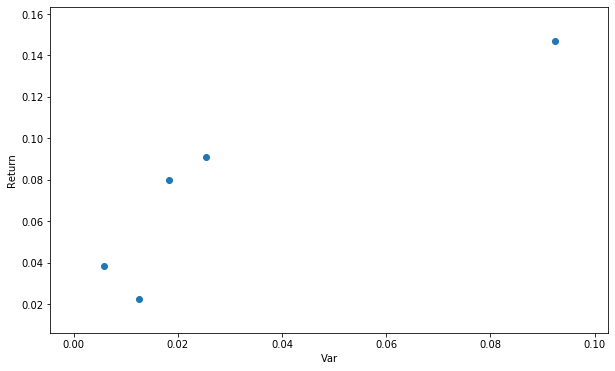

In [15]:
port_rets = [port_ret(op_minvar), port_ret(op_minret), port_ret(op_maxret), port_ret(op_maxspr), port_ret(op_minvar_st_ret)]
port_vars = [port_var(op_minvar), port_var(op_minret), port_var(op_maxret), port_var(op_maxspr), port_var(op_minvar_st_ret)]

fig1 = plt.figure(figsize = (10,6))
plt.scatter(port_vars, port_rets)
plt.xlabel('Var')
plt.ylabel('Return')
plt.show()

### Optimize for more points on efficiency frontier

In [16]:
eff_front_rets = np.linspace(port_ret(op_minret), port_ret(op_maxret), 40)
eff_front_rets

array([0.02243839, 0.02563803, 0.02883766, 0.0320373 , 0.03523693,
       0.03843657, 0.0416362 , 0.04483584, 0.04803547, 0.05123511,
       0.05443475, 0.05763438, 0.06083402, 0.06403365, 0.06723329,
       0.07043292, 0.07363256, 0.07683219, 0.08003183, 0.08323146,
       0.0864311 , 0.08963073, 0.09283037, 0.09603   , 0.09922964,
       0.10242928, 0.10562891, 0.10882855, 0.11202818, 0.11522782,
       0.11842745, 0.12162709, 0.12482672, 0.12802636, 0.13122599,
       0.13442563, 0.13762526, 0.1408249 , 0.14402454, 0.14722417])

In [17]:
eff_front_vars = []
for i in eff_front_rets:
    conctraint_eff_front = LinearConstraint([np.ones(50),np.array(return_mat)],[1,i],[1,i])
    res_eff_front = minimize(port_var, weight, method='SLSQP', constraints = conctraint_eff_front, bounds=bounds_optimize)
    w_opt = res_eff_front.x
    eff_front_var = port_var(w_opt)
    eff_front_vars.append(eff_front_var)
eff_front_vars = np.array(eff_front_vars)
eff_front_vars

array([0.0125083 , 0.00802085, 0.00693842, 0.00628522, 0.00591681,
       0.00579044, 0.00588247, 0.00614518, 0.00656494, 0.00712853,
       0.00783208, 0.00867785, 0.00966251, 0.01077987, 0.01202831,
       0.01340911, 0.01492164, 0.01656589, 0.01834185, 0.0202497 ,
       0.02228923, 0.02446021, 0.02676324, 0.02919721, 0.03176359,
       0.03446171, 0.0372894 , 0.04025001, 0.04334352, 0.04657536,
       0.04994794, 0.05346606, 0.05713617, 0.06097723, 0.06502452,
       0.06931146, 0.07388102, 0.07880204, 0.08419298, 0.09238106])

### Plot full efficiency frontier

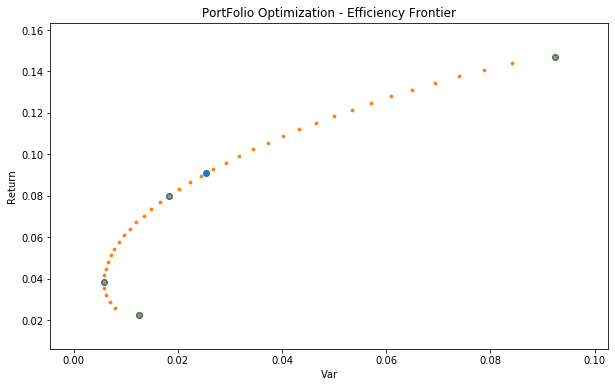

In [18]:
fig = plt.figure(figsize = (10,6))
plt.scatter(port_vars, port_rets)
plt.scatter(eff_front_vars, eff_front_rets, s = 8)
plt.xlabel('Var')
plt.ylabel('Return')
plt.title('PortFolio Optimization - Efficiency Frontier')
plt.show()

# V. TCA Portfolio Optimization

## 1) Traditional QP

### Get portfolio information table

In [19]:
a1 = 823.753028062354
a2 = 0.338038355593739
a3 = 0.780379773988063
a4 = 1.13791772697762
b1 = 0.910021492783546

investment = 500000000
weights = np.array(np.repeat(1/50, 50))

computed_vol = ((np.array(beta_sel)**2*mkt_v)+252*(np.array(SeY_sel)**2))**0.5

returns_sel = pd.read_csv('advs.csv')
indv_ret = return_mat
#indv_vol = returns_sel['Volatility']
indv_vol = computed_vol
adv = returns_sel['ADV']
price = returns_sel['Price']

In [20]:
indv_investment = investment * weights
shares = indv_investment/price
side = []
for w in weights:
    if w>0:
        side.append(1)
    else:
        side.append(0)
pct_adv = shares/adv
pov = pct_adv/(1+pct_adv)
mibp = a1*(pct_adv**a2)*(indv_vol**a3)*(b1*(pov**a4)+(1-b1))
midl = indv_investment*mibp/10000
ret_dl = indv_ret*indv_investment
net_ret = ret_dl - midl

traditionalqp_df_colnames = ['Stock', 'Weight', 'Return', 'Volatility', 'ADV', \
                             'Price', 'Invest$', 'Shares', 'Side', 'Size', 'POV', 'MI_bp'
                             , 'MI_$', 'Return_$', 'Net Return $']
traditionalqp_df_values = [tick_sel, weights, indv_ret, indv_vol, adv, \
                           price, indv_investment,shares, side, pct_adv, pov, mibp,\
                          midl, ret_dl, net_ret]
for i in range(len(traditionalqp_df_values)):
    traditionalqp_df_values[i] = list(traditionalqp_df_values[i])

traditionalqp_df = pd.DataFrame({traditionalqp_df_colnames[i]:traditionalqp_df_values[i]\
                                 for i in range(len(traditionalqp_df_colnames))}, index = sel)
traditionalqp_df

,Stock,Weight,Return,Volatility,ADV,Price,Invest$,Shares,Side,Size,POV,MI_bp,MI_$,Return_$,Net Return $
50,ATVI,0.02,0.118224,0.370549,7077200,60.7100,10000000.0,164717.509471,1,0.023274,0.022745,10.889044,10889.043971,1.182245e+06,1.171356e+06
51,AVB,0.02,0.050351,0.158740,800500,208.8400,10000000.0,47883.547213,1,0.059817,0.056441,9.415082,9415.081593,5.035051e+05,4.940900e+05
52,AVGO,0.02,0.110017,0.323754,2572100,262.9000,10000000.0,38037.276531,1,0.014788,0.014573,8.005921,8005.921080,1.100171e+06,1.092165e+06
53,AVY,0.02,0.087478,0.225202,656100,120.3600,10000000.0,83084.081090,1,0.126633,0.112400,21.201256,21201.256163,8.747849e+05,8.535837e+05
54,AWK,0.02,0.038507,0.159898,1273300,137.7100,10000000.0,72616.367729,1,0.057030,0.053953,9.187854,9187.853616,3.850696e+05,3.758818e+05
55,AXP,0.02,0.095592,0.210050,5097800,103.3000,10000000.0,96805.421104,1,0.018990,0.018636,6.368314,6368.314492,9.559231e+05,9.495548e+05
56,AZO,0.02,0.056146,0.258660,312800,1148.3000,10000000.0,8708.525647,1,0.027841,0.027086,8.969794,8969.793501,5.614624e+05,5.524926e+05
57,BA,0.02,0.104085,0.288961,7312700,231.0100,10000000.0,43288.169343,1,0.005920,0.005885,5.113068,5113.067661,1.040849e+06,1.035736e+06
58,BAC,0.02,0.106813,0.257412,69493300,23.6100,10000000.0,423549.343499,1,0.006095,0.006058,4.722764,4722.764439,1.068133e+06,1.063410e+06
59,BAX,0.02,0.083257,0.210961,2562200,82.9800,10000000.0,120510.966498,1,0.047034,0.044921,10.149338,10149.337503,8.325694e+05,8.224201e+05


### Traditional QP summary table

In [21]:
port_ret_dl = traditionalqp_df.sum()['Return_$']
port_mi_dl = traditionalqp_df.sum()['MI_$']
port_net_ret_dl = port_ret_dl-port_mi_dl
port_var_pct = np.dot(weights, np.dot(covmat, weights.T))
port_std_pct = port_var_pct**0.5
port_rf_pct = 0.02

port_ret_pct = port_ret_dl/investment
port_mi_pct = port_mi_dl/investment
port_net_ret_pct = port_net_ret_dl/investment
port_var_dl = port_var_pct*investment
port_std_dl = port_std_pct*investment
port_rf_dl = port_rf_pct*investment

port_res_index = ['Investment', 'Return', 'Market Inpact', 'Net Return', 'Variance', 'Risk', 'Risk Free']
port_stats_result = pd.DataFrame({'percentage':['NaN', port_ret_pct, port_mi_pct, port_net_ret_pct, port_var_pct, \
                                      port_std_pct, port_rf_pct],
                                 'dollars':[investment, port_ret_dl, port_mi_dl, port_net_ret_dl, port_var_dl,\
                                           port_std_dl, port_rf_dl]}, index = port_res_index)
port_stats_result

,percentage,dollars
Investment,NaN,5.000000e+08
Return,0.0853074,4.265369e+07
Market Inpact,0.00124311,6.215528e+05
Net Return,0.0840643,4.203214e+07
Variance,0.0217584,1.087919e+07
Risk,0.147507,7.375360e+07
Risk Free,0.02,1.000000e+07


### Optimize for Sharpe Ratio

In [22]:
port_sharpe_ratio = (port_ret_pct-port_rf_pct)/port_std_pct
port_sharpe_ratio

0.4427403772567254

In [23]:
res_port_maxspr = minimize(port_neg_spr, weights, method='SLSQP', \
                           constraints = constraint_optimize, bounds=bounds_optimize)
port_op_maxspr = res_port_maxspr.x
opt_port_w = pd.Series(port_op_maxspr, index = tick_sel)
print('max weight: \n',opt_port_w)
print('opt ret: ', port_ret(port_op_maxspr), 'opt var: ', port_var(port_op_maxspr))
print('max spr - sharpe ratio:', (port_ret(port_op_maxspr)-port_rf_pct)/((port_var(port_op_maxspr))**0.5))

max weight: 
 ATVI     0.011703
AVB      0.015693
AVGO     0.014806
AVY      0.025337
AWK      0.008222
AXP      0.050982
AZO      0.006366
BA       0.018444
BAC      0.031519
BAX      0.027180
BBY      0.009277
BDX      0.030140
BEN      0.024594
BF/B     0.014949
BIIB     0.005798
BK       0.024995
BKNG     0.017787
BKR      0.005261
BLK      0.055001
BLL      0.016017
BMY      0.011207
BR       0.025943
BRK/B    0.066898
BSX      0.023394
BWA      0.018943
BXP      0.019051
C        0.037451
CAG      0.006111
CAH      0.008760
CAT      0.028297
CB       0.027542
CBOE     0.007831
CBRE     0.032242
CCI      0.008948
CCL      0.016751
CDNS     0.022250
CDW      0.021425
CE       0.026121
CERN     0.017511
CF       0.010327
CFG      0.021041
CHD      0.007700
CHRW     0.013433
CHTR     0.010927
CI       0.013239
CINF     0.021573
CL       0.013132
CLX      0.008975
CMA      0.020970
CMCSA    0.017936
dtype: float64
opt ret:  0.0908682546352963 opt var:  0.025332520112470256
max spr - s

### Get new portfolio info and summary table with optimized weights

In [24]:
weights = port_op_maxspr

indv_ret = return_mat
#indv_vol = returns_sel['Volatility']
indv_vol = computed_vol
adv = returns_sel['ADV']
price = returns_sel['Price']

indv_investment = investment * weights
shares = indv_investment/price
side = []
for w in weights:
    if w>0:
        side.append(1)
    else:
        side.append(0)
pct_adv = shares/adv
pov = pct_adv/(1+pct_adv)
mibp = a1*(pct_adv**a2)*(indv_vol**a3)*(b1*(pov**a4)+(1-b1))
midl = indv_investment*mibp/10000
ret_dl = indv_ret*indv_investment
net_ret = ret_dl - midl

traditionalqp_df_colnames = ['Stock', 'Weight', 'Return', 'Volatility', 'ADV', \
                             'Price', 'Invest$', 'Shares', 'Side', 'Size', 'POV', 'MI_bp'
                             , 'MI_$', 'Return_$', 'Net Return $']
traditionalqp_df_values = [tick_sel, weights, indv_ret, indv_vol, adv, \
                           price, indv_investment,shares, side, pct_adv, pov, mibp,\
                          midl, ret_dl, net_ret]
for i in range(len(traditionalqp_df_values)):
    traditionalqp_df_values[i] = list(traditionalqp_df_values[i])

traditionalqp_df = pd.DataFrame({traditionalqp_df_colnames[i]:traditionalqp_df_values[i]\
                                 for i in range(len(traditionalqp_df_colnames))}, index = sel)
print('Portfolio Info with Optimized Sharpe Ratio')
traditionalqp_df

Portfolio Info with Optimized Sharpe Ratio


,Stock,Weight,Return,Volatility,ADV,Price,Invest$,Shares,Side,Size,POV,MI_bp,MI_$,Return_$,Net Return $
50,ATVI,0.011703,0.118224,0.370549,7077200,60.7100,5.851661e+06,96387.105553,1,0.013619,0.013436,8.593169,5028.431424,6.918096e+05,6.867812e+05
51,AVB,0.015693,0.050351,0.158740,800500,208.8400,7.846513e+06,37571.889860,1,0.046936,0.044831,8.119231,6370.765264,3.950759e+05,3.887052e+05
52,AVGO,0.014806,0.110017,0.323754,2572100,262.9000,7.402901e+06,28158.618963,1,0.010948,0.010829,7.074494,5237.177726,8.144456e+05,8.092084e+05
53,AVY,0.025337,0.087478,0.225202,656100,120.3600,1.266827e+07,105253.195751,1,0.160422,0.138245,25.751792,32623.077173,1.108202e+06,1.075579e+06
54,AWK,0.008222,0.038507,0.159898,1273300,137.7100,4.111017e+06,29852.713681,1,0.023445,0.022908,5.670836,2331.290605,1.583028e+05,1.559715e+05
55,AXP,0.050982,0.095592,0.210050,5097800,103.3000,2.549087e+07,246765.429927,1,0.048406,0.046171,10.287963,26224.912486,2.436731e+06,2.410506e+06
56,AZO,0.006366,0.056146,0.258660,312800,1148.3000,3.182792e+06,2771.742450,1,0.008861,0.008783,5.463141,1738.804142,1.787018e+05,1.769630e+05
57,BA,0.018444,0.104085,0.288961,7312700,231.0100,9.221931e+06,39920.051997,1,0.005459,0.005429,4.962557,4576.436116,9.598641e+05,9.552876e+05
58,BAC,0.031519,0.106813,0.257412,69493300,23.6100,1.575964e+07,667498.525203,1,0.009605,0.009514,5.616483,8851.375040,1.683339e+06,1.674487e+06
59,BAX,0.027180,0.083257,0.210961,2562200,82.9800,1.359025e+07,163777.370088,1,0.063921,0.060080,12.267149,16671.357034,1.131482e+06,1.114811e+06


In [25]:
port_ret_dl = traditionalqp_df.sum()['Return_$']
port_mi_dl = traditionalqp_df.sum()['MI_$']
port_net_ret_dl = port_ret_dl-port_mi_dl
port_var_pct = np.dot(weights, np.dot(covmat, weights.T))
port_std_pct = port_var_pct**0.5
port_rf_pct = 0.02

port_ret_pct = port_ret_dl/investment
port_mi_pct = port_mi_dl/investment
port_net_ret_pct = port_net_ret_dl/investment
port_var_dl = port_var_pct*investment
port_std_dl = port_std_pct*investment
port_rf_dl = port_rf_pct*investment

port_res_index = ['Investment', 'Return', 'Market Inpact', 'Net Return', 'Variance', 'Risk', 'Risk Free']
port_stats_result = pd.DataFrame({'percentages':['NaN', port_ret_pct, port_mi_pct, port_net_ret_pct, port_var_pct, \
                                      port_std_pct, port_rf_pct],
                                 'dollars':[investment, port_ret_dl, port_mi_dl, port_net_ret_dl, port_var_dl,\
                                           port_std_dl, port_rf_dl]}, index = port_res_index)
port_ret_pct_prev = port_ret_pct
port_mi_pct_prev = port_mi_pct
port_net_ret_pct_prev = port_net_ret_pct
port_std_pct_prev = port_std_pct

print('Portfolio Summary Table with Optimized Sharpe Ratio')
port_stats_result

Portfolio Summary Table with Optimized Sharpe Ratio


,percentages,dollars
Investment,NaN,5.000000e+08
Return,0.0908683,4.543413e+07
Market Inpact,0.00124756,6.237785e+05
Net Return,0.0896207,4.481035e+07
Variance,0.0253325,1.266626e+07
Risk,0.159162,7.958097e+07
Risk Free,0.02,1.000000e+07


### Get optimized sharpe ratio

In [26]:
port_sharpe_ratio = (port_ret_pct-port_rf_pct)/port_std_pct
print('The optimized sharpe ratio of the portfolio is ', port_sharpe_ratio)

The optimized sharpe ratio of the portfolio is  0.44525882806196276


## 2) TCA Optimization

### Defind function and optimize for net return while holding risk at 0.0311
### In this step, use non-linear constraints to solve the optimization equation with risk limit

In [27]:
def neg_port_net_ret_mg(weights):
    global a1
    global a2
    global a3
    global a4
    global b1
    global investment
    global indv_ret
    global indv_vol
    global price
    
    indv_investment = investment * weights
    shares = indv_investment/price
    pct_adv = shares/adv
    
    mibp = a1*(pct_adv**a2)*(indv_vol**a3)*(b1*(pov**a4)+(1-b1))
    midl = indv_investment*mibp/10000
    ret_dl = indv_ret*indv_investment
    net_ret = ret_dl - midl
    net_ret_sum = sum(net_ret)
    port_net_ret_margin = net_ret_sum/investment
    
    return -port_net_ret_margin

# def port_var_311(weight):
#     global covmat
#     port_v = np.dot(weight.T, np.dot(covmat,weight))-0.031079115773699692
#     return port_v

port_var_target = 0.025332520112470256
var_constraints = NonlinearConstraint(port_var, lb = port_var_target, ub = port_var_target)
# equl_const = {'type':'eq','fun': port_var_311}

res_maxnetret_holdrisk = minimize(neg_port_net_ret_mg, weights, method='trust-constr', \
                           constraints = [var_constraints,constraint_optimize], bounds=bounds_optimize)
res_maxnetret_holdrisk_w = res_maxnetret_holdrisk.x
res_maxnetret_holdrisk_w_sr = pd.Series(res_maxnetret_holdrisk_w, index = tick_sel)
print(res_maxnetret_holdrisk_w)
print('max net ret while holding variance at', round(port_var_target,4), ': ', -neg_port_net_ret_mg(res_maxnetret_holdrisk_w),\
      '\nret before MI: ', port_ret(res_maxnetret_holdrisk_w))

[0.01439931 0.01530203 0.01910617 0.01129859 0.00982445 0.05481912
 0.00836112 0.02574128 0.04313812 0.02522824 0.00978801 0.03654365
 0.01880806 0.00658762 0.00765743 0.02536149 0.02414754 0.00519491
 0.05185697 0.01609221 0.01555065 0.01654111 0.0841825  0.02644733
 0.01578518 0.01388851 0.04790002 0.00613104 0.00925187 0.03272177
 0.02911817 0.0068119  0.01304615 0.01224059 0.01936255 0.01754789
 0.01756969 0.01415742 0.01700509 0.00903434 0.01734026 0.007762
 0.01142451 0.01500962 0.01709811 0.01097418 0.01714279 0.01175953
 0.01337379 0.02456514]
max net ret while holding variance at 0.0253 :  0.08974377265788998 
ret before MI:  0.09078351088966988


### Get new portfolio info and summary table with optimized weights while holding risk at 0.0311

In [28]:
weights = res_maxnetret_holdrisk_w

indv_ret = return_mat
#indv_vol = returns_sel['Volatility']
indv_vol = computed_vol
adv = returns_sel['ADV']
price = returns_sel['Price']

indv_investment = investment * weights
shares = indv_investment/price
side = []
for w in weights:
    if w>0:
        side.append(1)
    else:
        side.append(0)
pct_adv = shares/adv
pov = pct_adv/(1+pct_adv)
mibp = a1*(pct_adv**a2)*(indv_vol**a3)*(b1*(pov**a4)+(1-b1))
midl = indv_investment*mibp/10000
ret_dl = indv_ret*indv_investment
net_ret = ret_dl - midl

traditionalqp_df_colnames = ['Stock', 'Weight', 'Return', 'Volatility', 'ADV', \
                             'Price', 'Invest$', 'Shares', 'Side', 'Size', 'POV', 'MI_bp'
                             , 'MI_$', 'Return_$', 'Net Return $']
traditionalqp_df_values = [tick_sel, weights, indv_ret, indv_vol, adv, \
                           price, indv_investment,shares, side, pct_adv, pov, mibp,\
                          midl, ret_dl, net_ret]
for i in range(len(traditionalqp_df_values)):
    traditionalqp_df_values[i] = list(traditionalqp_df_values[i])

traditionalqp_df = pd.DataFrame({traditionalqp_df_colnames[i]:traditionalqp_df_values[i]\
                                 for i in range(len(traditionalqp_df_colnames))}, index = sel)
print('Portfolio Data Holding Variance at', port_var_pct)
traditionalqp_df

Portfolio Data Holding Variance at 0.025332520112470256


,Stock,Weight,Return,Volatility,ADV,Price,Invest$,Shares,Side,Size,POV,MI_bp,MI_$,Return_$,Net Return $
50,ATVI,0.014399,0.118224,0.370549,7077200,60.7100,7.199653e+06,118590.886614,1,0.016757,0.016481,9.385179,6757.003055,8.511752e+05,8.444182e+05
51,AVB,0.015302,0.050351,0.158740,800500,208.8400,7.651015e+06,36635.774580,1,0.045766,0.043763,8.000579,6121.255249,3.852325e+05,3.791112e+05
52,AVGO,0.019106,0.110017,0.323754,2572100,262.9000,9.553085e+06,36337.331907,1,0.014127,0.013931,7.853183,7502.212517,1.051002e+06,1.043500e+06
53,AVY,0.011299,0.087478,0.225202,656100,120.3600,5.649297e+06,46936.663827,1,0.071539,0.066763,13.908698,7857.436572,4.941920e+05,4.863345e+05
54,AWK,0.009824,0.038507,0.159898,1273300,137.7100,4.912226e+06,35670.802501,1,0.028014,0.027251,6.181782,3036.631033,1.891549e+05,1.861183e+05
55,AXP,0.054819,0.095592,0.210050,5097800,103.3000,2.740956e+07,265339.386686,1,0.052050,0.049475,10.745332,29452.481466,2.620143e+06,2.590691e+06
56,AZO,0.008361,0.056146,0.258660,312800,1148.3000,4.180560e+06,3640.651439,1,0.011639,0.011505,6.085854,2544.227797,2.347227e+05,2.321785e+05
57,BA,0.025741,0.104085,0.288961,7312700,231.0100,1.287064e+07,55714.636185,1,0.007619,0.007561,5.620746,7234.258415,1.339639e+06,1.332405e+06
58,BAC,0.043138,0.106813,0.257412,69493300,23.6100,2.156906e+07,913556.176040,1,0.013146,0.012975,6.372479,13744.838181,2.303862e+06,2.290117e+06
59,BAX,0.025228,0.083257,0.210961,2562200,82.9800,1.261412e+07,152014.005968,1,0.059329,0.056007,11.693786,14750.685059,1.050213e+06,1.035463e+06


In [29]:
port_ret_dl = traditionalqp_df.sum()['Return_$']
port_mi_dl = traditionalqp_df.sum()['MI_$']
port_net_ret_dl = port_ret_dl-port_mi_dl
port_var_pct = np.dot(weights, np.dot(covmat, weights.T))
port_std_pct = port_var_pct**0.5
port_rf_pct = 0.02

port_ret_pct = port_ret_dl/investment
port_mi_pct = port_mi_dl/investment
port_net_ret_pct = port_net_ret_dl/investment
port_var_dl = port_var_pct*investment
port_std_dl = port_std_pct*investment
port_rf_dl = port_rf_pct*investment

port_res_index = ['Investment', 'Return', 'Market Inpact', 'Net Return', 'Variance', 'Risk', 'Risk Free']
port_stats_result = pd.DataFrame({'percentages':['NaN', port_ret_pct, port_mi_pct, port_net_ret_pct, port_var_pct, \
                                      port_std_pct, port_rf_pct],
                                 'dollars':[investment, port_ret_dl, port_mi_dl, port_net_ret_dl, port_var_dl,\
                                           port_std_dl, port_rf_dl]}, index = port_res_index)
print('Portfolio Summary Table Holding Variance at', port_var_pct)
port_stats_result

Portfolio Summary Table Holding Variance at 0.025332521654254446


,percentages,dollars
Investment,NaN,5.000000e+08
Return,0.0907835,4.539176e+07
Market Inpact,0.000997428,4.987138e+05
Net Return,0.0897861,4.489304e+07
Variance,0.0253325,1.266626e+07
Risk,0.159162,7.958097e+07
Risk Free,0.02,1.000000e+07


## 3) Make Comparison Table and Plot

In [30]:
compar = {'Traditional QP': [port_ret_pct_prev, port_mi_pct_prev, port_net_ret_pct_prev, port_std_pct_prev],
          'TCA Optimization':[port_ret_pct, port_mi_pct, port_net_ret_pct, port_std_pct]}
compar_optimization = pd.DataFrame(compar, index = ['Return', 'Market Impact', 'Net Return', 'Stdev(Risk)'])
compar_optimization

,Traditional QP,TCA Optimization
Return,0.090868,0.090784
Market Impact,0.001248,0.000997
Net Return,0.089621,0.089786
Stdev(Risk),0.159162,0.159162


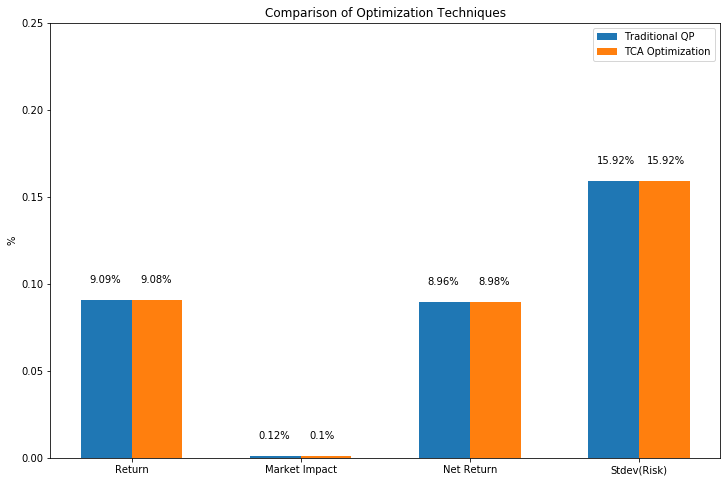

In [31]:
fig = plt.figure(figsize = (12,8))
x = np.array([1,2,3,4])
w = 0.3
qp = compar_optimization['Traditional QP']
tca = compar_optimization['TCA Optimization']
plt.bar(x-w/2,height = qp,width = w)
plt.bar(x+w/2,height = tca,width = w)
plt.xticks(x, compar_optimization.index)
plt.ylim(0,0.25)
for i in range(len(compar_optimization)):
    plt.annotate(f'{round(qp[i]*100,2)}%', (x[i]-0.25, qp[i]+0.01))
    plt.annotate(f'{round(tca[i]*100,2)}%', (x[i]+0.05, tca[i]+0.01))
plt.legend(compar_optimization.columns)
plt.ylabel('%')
plt.title('Comparison of Optimization Techniques')
plt.show()

# VI. Cost Curve and Pre-Trade Analysis

## 1) Cost Curve

### Compute for I-Star model and MI with size ~ [1%-100%] and POV ~ [1%-60%]

In [32]:
i = 0
adv_i = adv[i]
price_i = price[i]
vol_i = indv_vol[i]

size = np.linspace(0, 1, 21)
size[0] = size[0]+0.01

shares = adv_i*size
trade_value = shares*price_i
istar_i = a1*((size)**a2)*(vol_i**a3)
istar_i_df = pd.DataFrame(istar_i, columns = pd.MultiIndex([['I-Star'],['I-Star']],[[0],[0]]), index = size)

pov_series = np.linspace(0, 6, 13)/10
pov_series[0] = pov_series[0] + 0.01
pov_series
MI_size_pov = np.ones((21,13))
for i in range(21):
    for j in range(13):
        MI_size_pov[i][j] = istar_i[i]*(b1*(pov_series[j]**a4)+(1-b1))
mtid = pd.MultiIndex(levels = [['Percentage of Volume (POV)'], pov_series], codes = [list(np.repeat(0,13)),[i for i in range(13)]])
MI_size_pov = pd.DataFrame(MI_size_pov, columns = mtid, index = size)
MI_size_pov

Percentage of Volume (POV)                                              \
                           0.01       0.05       0.10       0.15       0.20   
0.01                   7.586937   9.610073  12.502435  15.610490  18.867460   
0.05                  13.072093  16.557903  21.541368  26.896465  32.508139   
0.10                  16.523605  20.929797  27.229080  33.998118  41.091481   
0.15                  18.950925  24.004387  31.229035  38.992446  47.127824   
0.20                  20.886444  26.456032  34.418556  42.974870  51.941140   
0.25                  22.522874  28.528833  37.115212  46.341904  56.010671   
0.30                  23.954665  30.342426  39.474646  49.287883  59.571299   
0.35                  25.236010  31.965455  41.586161  51.924312  62.757792   
0.40                  26.401231  33.441396  43.506318  54.321813  65.655507   
0.45                  27.473608  34.799733  45.273477  56.528279  68.322331   
0.50                  28.469739  36.061492  46.914991  58.577867  70.799544   
0.55                  29.401927  37.242258  48.451134  60.495890  73.117743   
0.60                  30.279576  38.353941  49.897402  62.301694  75.300309   
0.65                  31.110050  39.405870  51.265932  64.010435  77.365562   
0.70                  31.899242  40.405508  52.566434  65.634236  79.328153   
0.75                  32.651947  41.358930  53.806809  67.182963  81.200006   
0.80                  33.372126  42.271151  54.993583  68.664765  82.990970   
0.85                  34.063091  43.146370  56.132219  70.086461  84.709289   
0.90                  34.727649  43.988139  57.227336  71.453820  86.361934   
0.95                  35.368195  44.799493  58.282885  72.771774  87.954865   
1.00                  35.986795  45.583050  59.302270  74.044574  89.493222   

                                                                              \
            0.25        0.30        0.35        0.40        0.45        0.50   
0.01   22.239842   25.707143   29.255424   32.874535   36.556735   40.295906   
0.05   38.318664   44.292734   50.406328   56.641962   62.986296   69.428789   
0.10   48.436198   55.987642   63.715449   71.597519   79.616989   87.760538   
0.15   55.551482   64.212233   73.075257   82.115204   91.312735  100.652572   
0.20   61.225132   70.770434   80.538666   90.501892  100.638797  110.932541   
0.25   66.022054   76.315220   86.848783   97.592616  108.523736  119.623984   
0.30   70.219112   81.166620   92.369806  103.796631  115.422649  127.228545   
0.35   73.975160   85.508255   97.310704  109.348755  121.596652  134.034051   
0.40   77.390814   89.456426  101.803830  114.397714  127.211133  140.222804   
0.45   80.534308   93.090006  105.938942  119.044370  132.378250  145.918434   
0.50   83.454300   96.465239  109.780049  123.360649  137.177986  151.209107   
0.55   86.186855   99.623813  113.374591  127.399863  141.669623  156.160166   
0.60   88.759535  102.597586  116.758826  131.202752  145.898464  160.821551   
0.65   91.193932  105.411518  119.961156  134.801235  149.900004  165.232385   
0.70   93.507318  108.085572  123.004302  138.220840  153.702631  169.423960   
0.75   95.713747  110.635995  125.906752  141.482344  157.329449  173.421743   
0.80   97.824830  113.076206  128.683778  144.602909  160.799541  177.246770   
0.85   99.850281  115.417436  131.348160  147.596895  164.128876  180.916644   
0.90  101.798321  117.669185  133.910712  150.476452  167.330967  184.446257   
0.95  103.675975  119.839574  136.380673  153.251966  170.417359  187.848338   
1.00  105.489298  121.935603  138.766011  155.932388  173.398009  191.133861   

                              
            0.55        0.60  
0.01   44.087085   47.926160  
0.05   75.960892   82.575517  
0.10   96.017356  104.378484  
0.15  110.122317  119.711697  
0.20  121.369462  131.938235  
0.25  130.878626  142.275451  
0.30  139.198651  151.319978  
0.35  146.644443  159.414145  
0.40  153.415455  166.774772  
0.45 

### Compute for I-Star model and MI with size ~ [1%-100%] and Trade Time in Days ~ [0.1-5]

In [33]:
trade_time_days = np.linspace(0, 5, 21)
trade_time_days[0] = trade_time_days[0] + 0.1
trade_time_days
MI_size_time = np.ones((21,21))
for i in range(21):
    for j in range(21):
        MI_size_time[i][j] = istar_i[i]*(b1*((size[i]/(size[i]+trade_time_days[j]))**a4)+(1-b1))
mtid_2 = pd.MultiIndex(levels = [['Trade Time in Days'], trade_time_days], codes = [list(np.repeat(0,21)),[i for i in range(21)]])
MI_size_time = pd.DataFrame(MI_size_time, columns = mtid_2, index = size)
MI_size_time

Trade Time in Days                                                  \
                   0.10        0.25        0.50        0.75        1.00   
0.01          11.957553    8.988286    8.031336    7.728386    7.582592   
0.05          48.354142   28.742029   20.602550   17.757736   16.333740   
0.10          87.760538   53.810952   36.330980   29.574496   26.042380   
0.15         119.711697   77.574436   52.281226   41.668005   35.903898   
0.20         146.218734   99.504452   68.019019   53.871521   45.923692   
0.25         168.806536  119.623984   83.312920   66.022054   56.010671   
0.30         188.489342  138.104032   98.056935   78.011021   66.085388   
0.35         205.949659  155.140627  112.212562   89.770877   76.088702   
0.40         221.661360  170.916943  125.777280  101.261641   85.978537   
0.45         235.964161  185.593327  138.767488  112.461511   95.725722   
0.50         249.108748  199.306749  151.209107  123.360649  105.310589   
0.55         261.284844  212.173234  163.132309  133.957082  114.720417   
0.60         272.639223  224.290956  174.568565  144.253978  123.947565   
0.65         283.287619  235.743187  185.548988  154.257813  132.988099   
0.70         293.322826  246.600850  196.103446  163.977140  141.840797   
0.75         302.820343  256.924656  206.260115  173.421743  150.506406   
0.80         311.842397  266.766847  216.045289  182.602066  158.987098   
0.85         320.440873  276.172620  225.483342  191.528817  167.286061   
0.90         328.659475  285.181282  234.596777  200.212709  175.407198   
0.95         336.535362  293.827190  243.406323  208.664278  183.354897   
1.00         344.100393  302.140525  251.931046  216.893771  191.133861   

                                                                  ...  \
            1.25        1.50        1.75        2.00        2.25  ...   
0.01    7.497699    7.442480    7.403853    7.375404    7.353629  ...   
0.05   15.486582   14.928009   14.533589   14.241083   14.016012  ...   
0.10   23.888931   22.446430   21.416517   20.646447   20.050165  ...   
0.15   32.310540   29.868009   28.105907   26.778131   25.743813  ...   
0.20   40.867306   37.383248   34.845132   32.918524   31.409104  ...   
0.25   49.521763   44.993661   41.664535   39.119826   37.115212  ...   
0.30   58.222230   52.669888   48.552215   45.383845   42.874852  ...   
0.35   66.923613   60.379949   55.487222   51.698680   48.683530  ...   
0.40   75.590073   68.095580   62.448344   58.049232   54.531333  ...   
0.45   84.194077   75.793340   69.416591   64.420665   60.407101  ...   
0.50   92.714861   83.454300   76.375735   70.799544   66.300016  ...   
0.55  101.137001   91.063401   83.312205   77.174130   72.200188  ...   
0.60  109.449249   98.608794   90.214801   83.534356   78.098829  ...   
0.65  117.643606  106.081252   97.074354   89.871681   83.988253  ...   
0.70  125.714598  113.473683  103.883418   96.178912   89.861802  ...   
0.75  133.658721  120.780727  110.635995  102.450030   95.713747  ...   
0.80  141.473998  127.998430  117.327297  108.680026  101.539182  ...   
0.85  149.159644  135.123977  123.953549  114.864758  107.333928  ...   
0.90  156.715796  142.155477  130.511823  121.000826  113.094438  ...   
0.95  164.143303  149.091792  136.999898  127.085464  118.817721  ...   
1.00  171.443563  155.932388  143.416146  133.116450  124.501266  ...   

                                                                           \
            2.75        3.00        3.25       3.50       3.75       4.00   
0.01    7.322588    7.311168    7.301610   7.293500   7.286537   7.280498   
0.05   13.693354   13.574086   13.474031  13.388965  13.315807  13.252261   
0.10   19.189486   18.869551   18.600388  18.370990  18.173290  18.001251   
0.15   24.241056   23.679412   23.205595  22.800821  22.451267  22.146540   
0.20   29.202230   28.373111   27.671776  27.071264  26.551642  26.097866   
0.25   34.166556   33.053158   32.108918  31.298620  30.5961

### Order Characteristics table

In [34]:
order_char = pd.DataFrame(np.transpose([size, shares, trade_value]), columns = pd.MultiIndex([['Order Characteristics'],['Size','Shares','Trade Values']], [[0,0,0],[0,1,2]]))
order_char.set_index(order_char['Order Characteristics']['Size'], inplace = True)
order_char.drop('Size', axis = 1, level = 1, inplace = True)
order_char

Order Characteristics              
                    Shares  Trade Values
Size                                    
0.01               70772.0  4.296568e+06
0.05              353860.0  2.148284e+07
0.10              707720.0  4.296568e+07
0.15             1061580.0  6.444852e+07
0.20             1415440.0  8.593136e+07
0.25             1769300.0  1.074142e+08
0.30             2123160.0  1.288970e+08
0.35             2477020.0  1.503799e+08
0.40             2830880.0  1.718627e+08
0.45             3184740.0  1.933456e+08
0.50             3538600.0  2.148284e+08
0.55             3892460.0  2.363112e+08
0.60             4246320.0  2.577941e+08
0.65             4600180.0  2.792769e+08
0.70             4954040.0  3.007598e+08
0.75             5307900.0  3.222426e+08
0.80             5661760.0  3.437254e+08
0.85             6015620.0  3.652083e+08
0.90             6369480.0  3.866911e+08
0.95             6723340.0  4.081740e+08
1.00             7077200.0  4.296568e+08

### Concatenate table and display full Cost Data for certain stock

In [35]:
cost_curve = pd.concat([order_char, istar_i_df, MI_size_pov, MI_size_time], axis = 1)
cost_curve

Order Characteristics                    I-Star  \
                    Shares  Trade Values      I-Star   
0.01               70772.0  4.296568e+06   80.030653   
0.05              353860.0  2.148284e+07  137.890717   
0.10              707720.0  4.296568e+07  174.298927   
0.15             1061580.0  6.444852e+07  199.903461   
0.20             1415440.0  8.593136e+07  220.320242   
0.25             1769300.0  1.074142e+08  237.582091   
0.30             2123160.0  1.288970e+08  252.685312   
0.35             2477020.0  1.503799e+08  266.201551   
0.40             2830880.0  1.718627e+08  278.492872   
0.45             3184740.0  1.933456e+08  289.804816   
0.50             3538600.0  2.148284e+08  300.312483   
0.55             3892460.0  2.363112e+08  310.145654   
0.60             4246320.0  2.577941e+08  319.403509   
0.65             4600180.0  2.792769e+08  328.163752   
0.70             4954040.0  3.007598e+08  336.488531   
0.75             5307900.0  3.222426e+08  344.428424   
0.80             5661760.0  3.437254e+08  352.025212   
0.85             6015620.0  3.652083e+08  359.313852   
0.90             6369480.0  3.866911e+08  366.323924   
0.95             6723340.0  4.081740e+08  373.080710   
1.00             7077200.0  4.296568e+08  379.606002   

     Percentage of Volume (POV)                                              \
                           0.01       0.05        0.1       0.15        0.2   
0.01                   7.586937   9.610073  12.502435  15.610490  18.867460   
0.05                  13.072093  16.557903  21.541368  26.896465  32.508139   
0.10                  16.523605  20.929797  27.229080  33.998118  41.091481   
0.15                  18.950925  24.004387  31.229035  38.992446  47.127824   
0.20                  20.886444  26.456032  34.418556  42.974870  51.941140   
0.25                  22.522874  28.528833  37.115212  46.341904  56.010671   
0.30                  23.954665  30.342426  39.474646  49.287883  59.571299   
0.35                  25.236010  31.965455  41.586161  51.924312  62.757792   
0.40                  26.401231  33.441396  43.506318  54.321813  65.655507   
0.45                  27.473608  34.799733  45.273477  56.528279  68.322331   
0.50                  28.469739  36.061492  46.914991  58.577867  70.799544   
0.55                  29.401927  37.242258  48.451134  60.495890  73.117743   
0.60                  30.279576  38.353941  49.897402  62.301694  75.300309   
0.65                  31.110050  39.405870  51.265932  64.010435  77.365562   
0.70                  31.899242  40.405508  52.566434  65.634236  79.328153   
0.75                  32.651947  41.358930  53.806809  67.182963  81.200006   
0.80                  33.372126  42.271151  54.993583  68.664765  82.990970   
0.85                  34.063091  43.146370  56.132219  70.086461  84.709289   
0.90                  34.727649  43.988139  57.227336  71.453820  86.361934   
0.95                  35.368195  44.799493  58.282885  72.771774  87.954865   
1.00                  35.986795  45.583050  59.302270  74.044574  89.493222   

                              ... Trade Time in Days                          \
            0.25         0.3  ...               2.75         3.0        3.25   
0.01   22.239842   25.707143  ...           7.322588    7.311168    7.301610   
0.05   38.318664   44.292734  ...          13.693354   13.574086   13.474031   
0.10   48.436198   55.987642  ...          19.189486   18.869551   18.600388   
0.15   55.551482   64.212233  ...          24.241056   23.679412   23.205595   
0.20   61.225132   70.770434  ...          29.202230   28.373111   27.671776   
0.25   66.022054   76.315220  ...          34.166556   33.053158   32.108918   
0.30   70.219112   81.166620  ...          39.162756   37.754259   36.556757   
0.35   73.975160   85.508255  ...          44.197521   42.487367   41.029855   
0.40   77.390814   89.456426  ...          49.269016   47.253798   45.532233   
0.45   80.534308  

### Plot cost curve for each stock

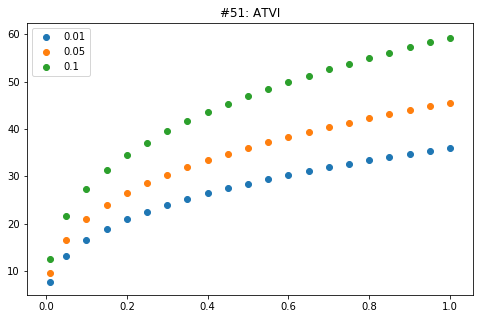

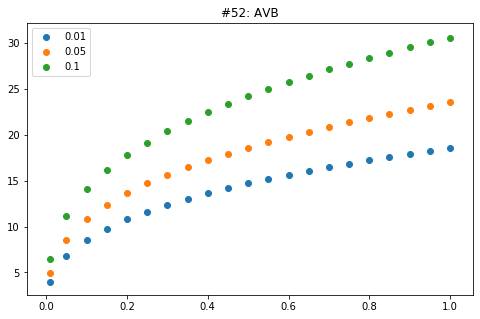

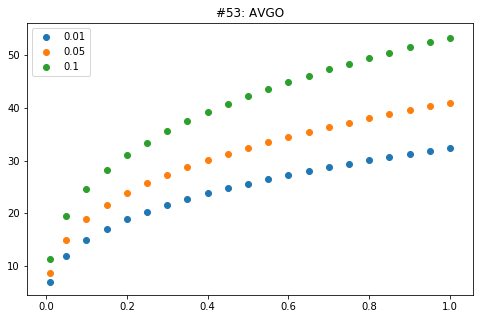

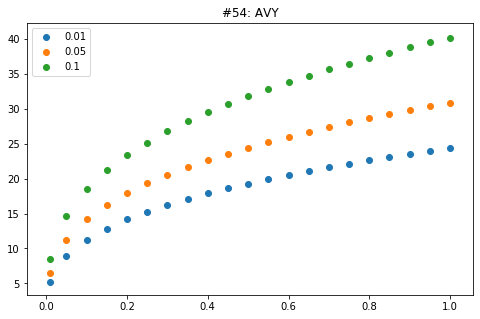

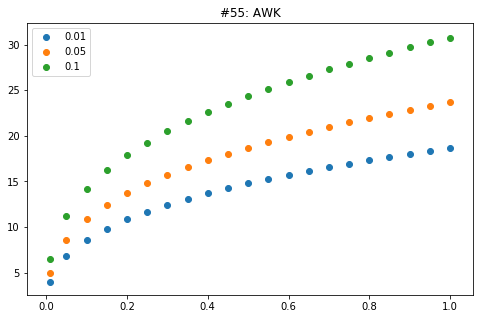

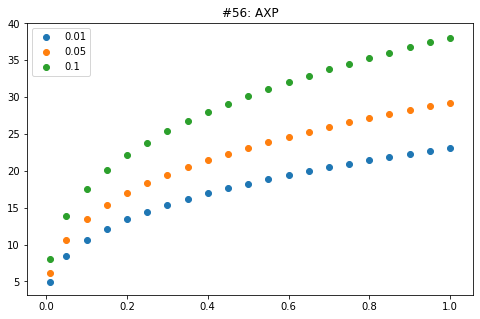

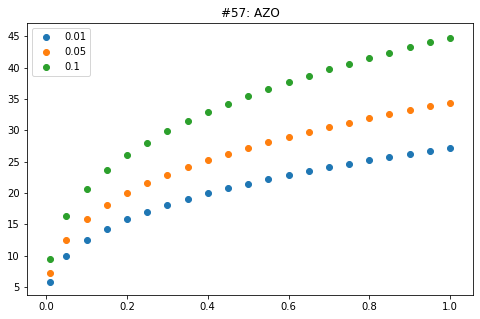

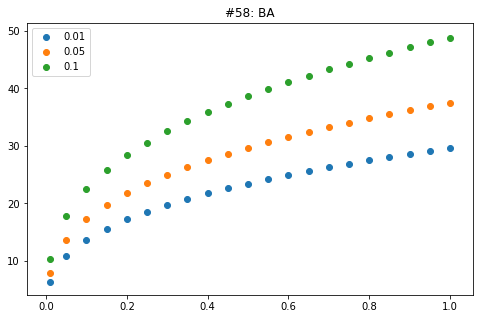

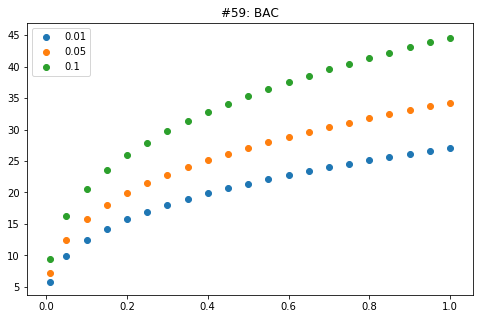

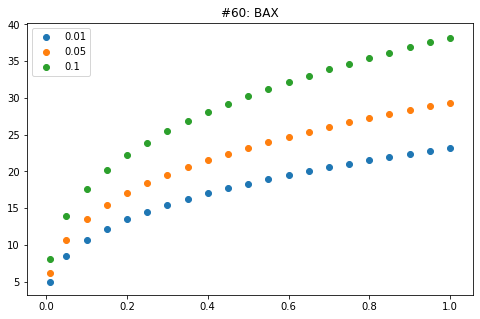

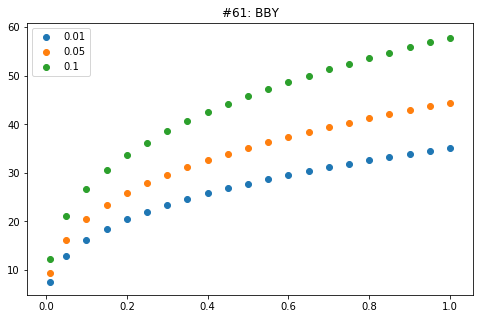

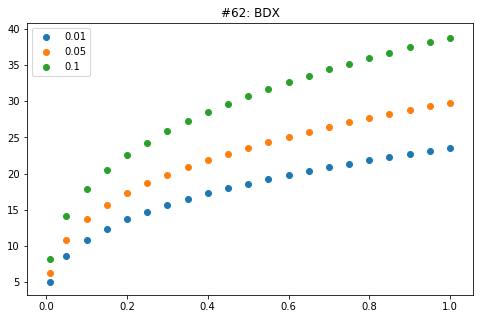

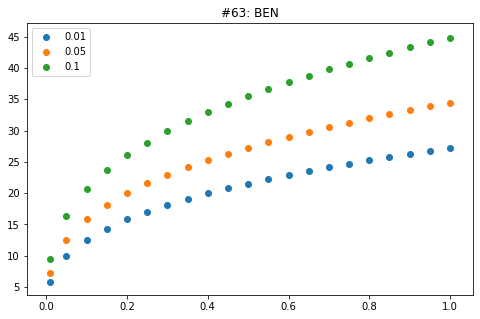

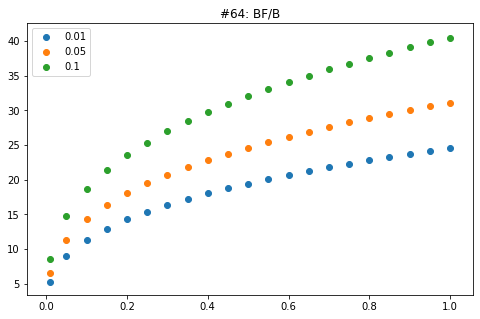

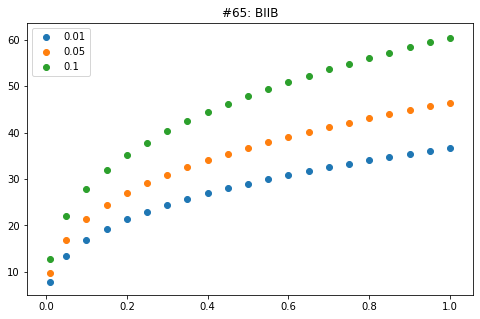

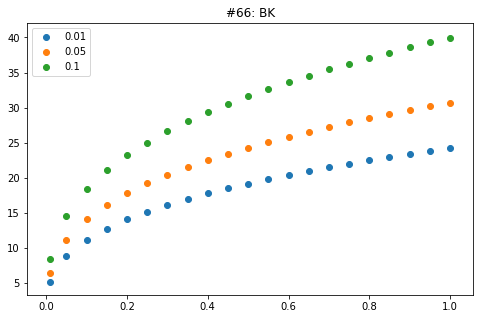

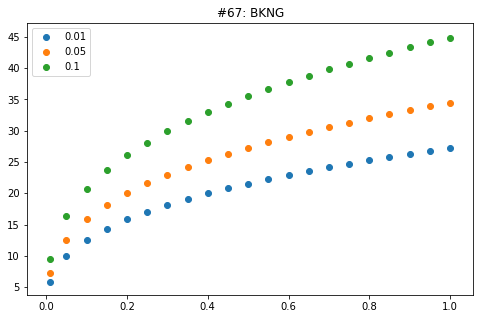

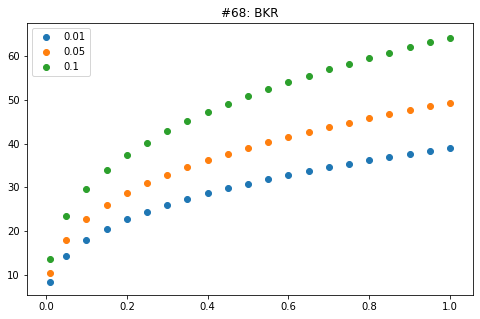

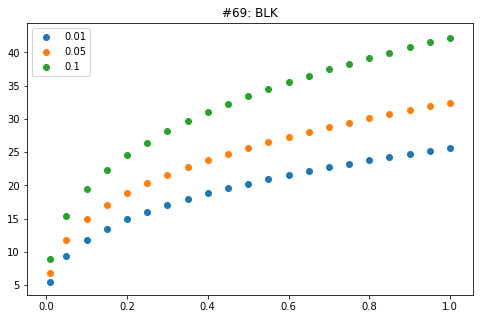

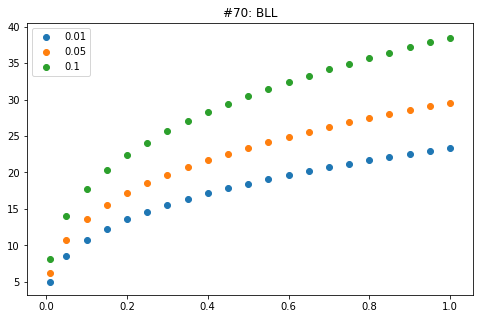

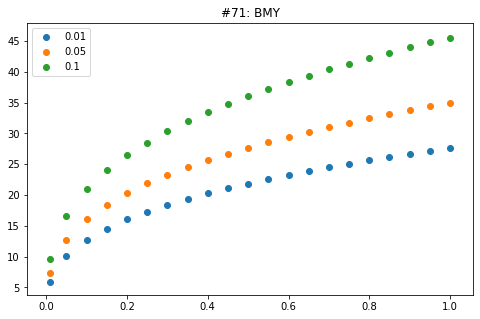

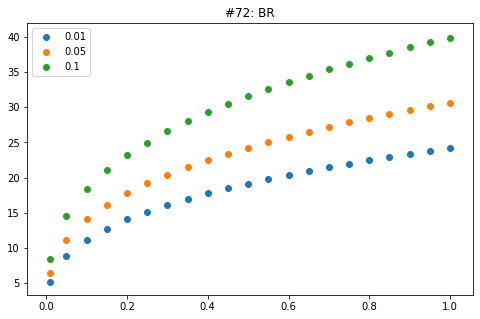

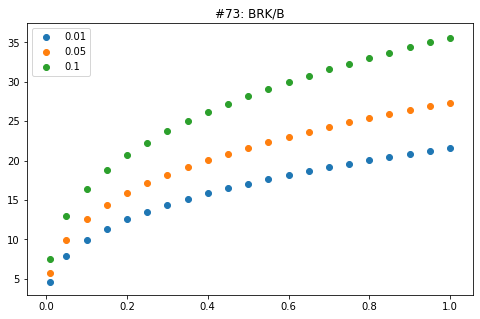

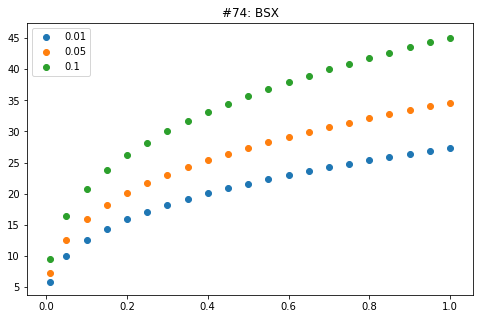

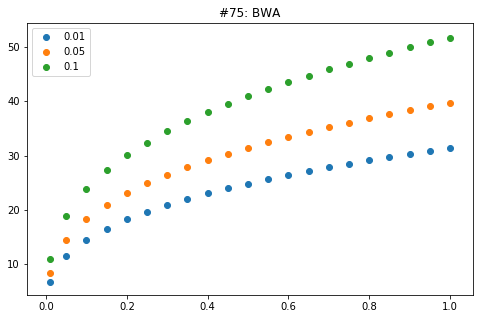

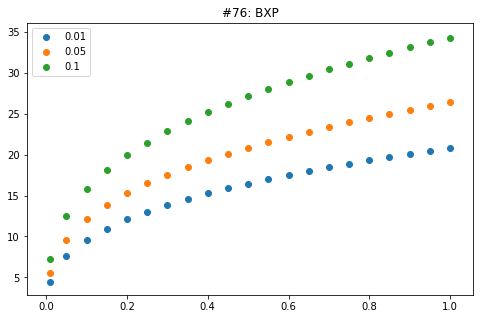

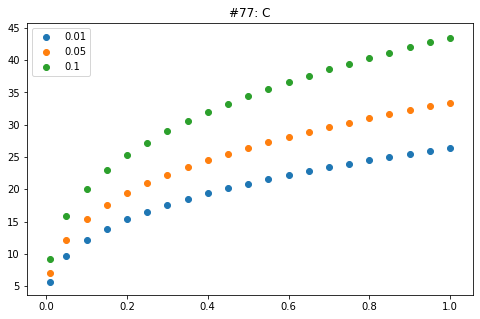

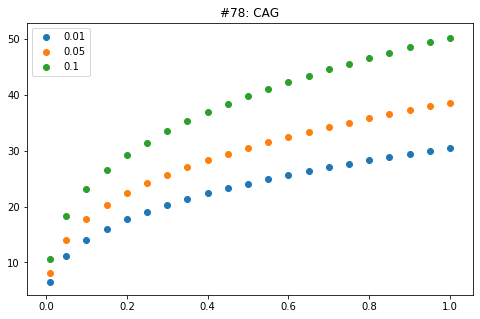

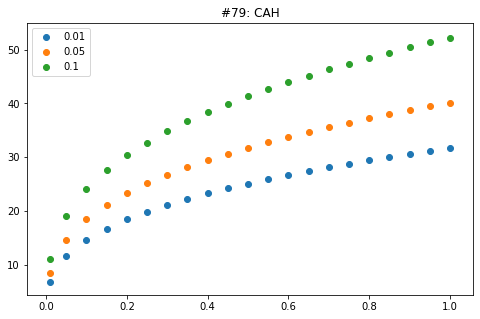

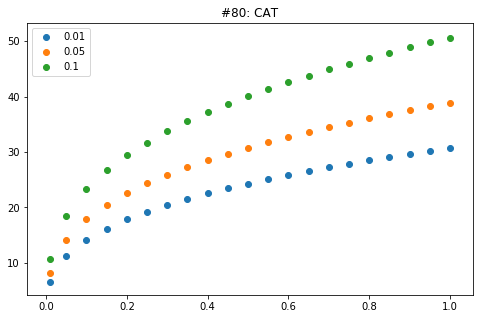

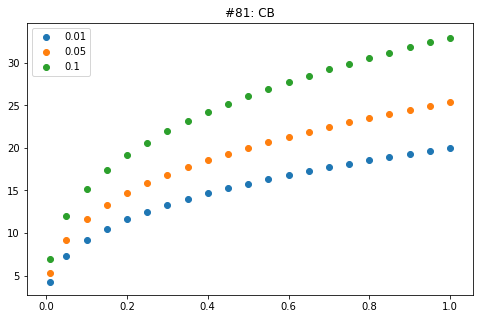

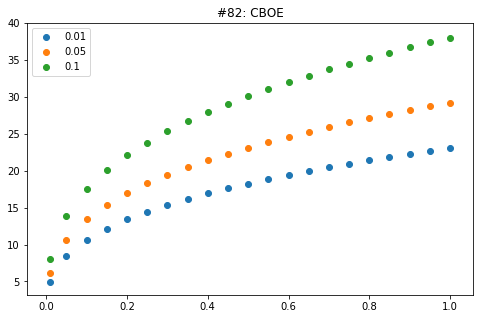

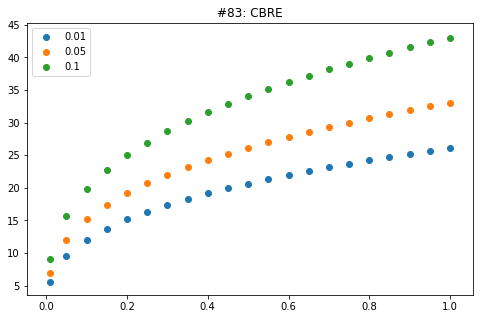

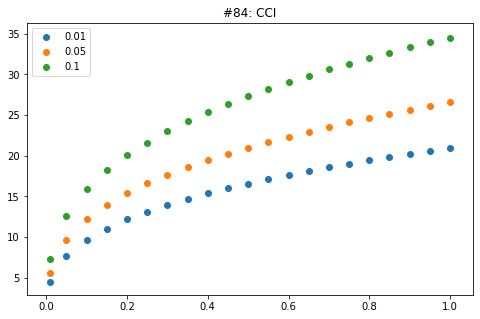

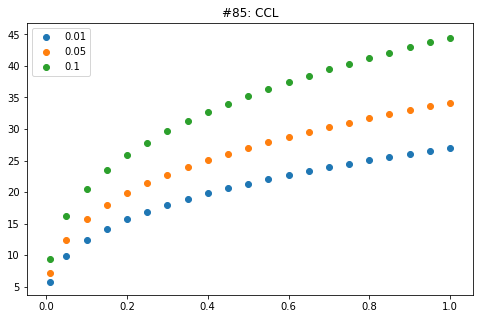

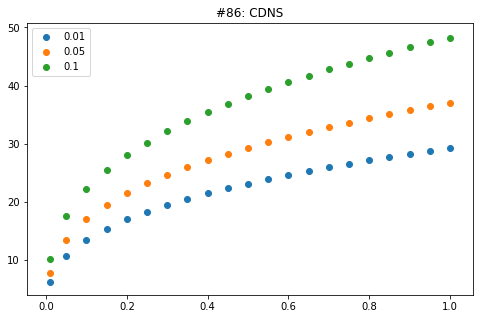

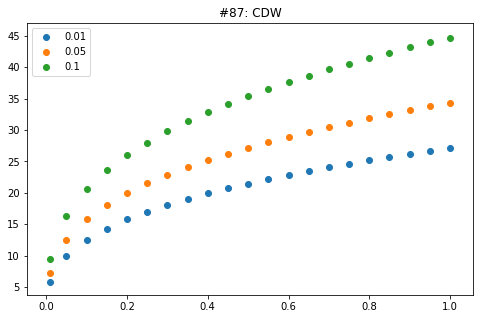

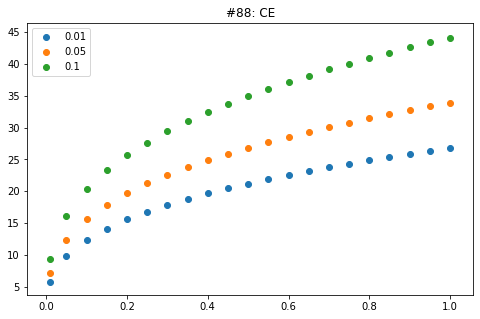

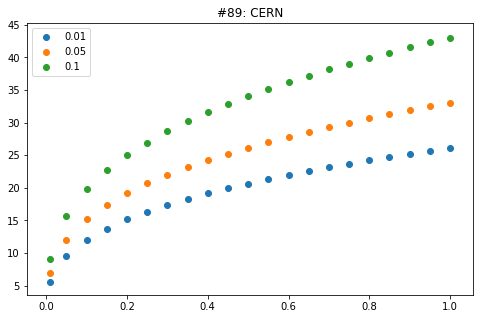

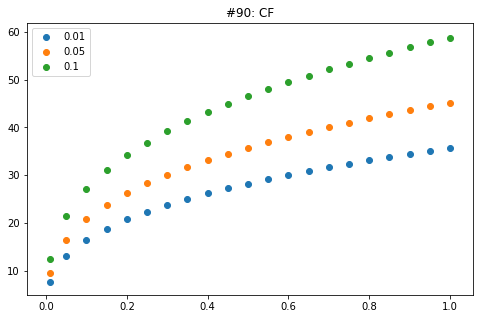

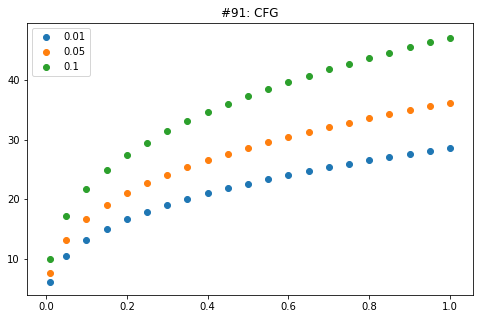

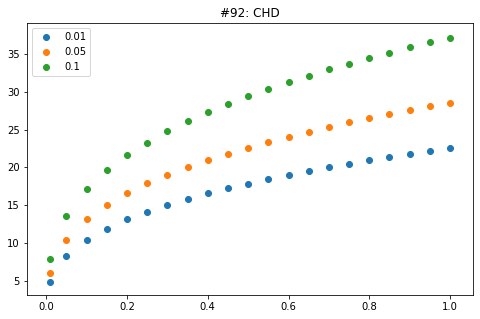

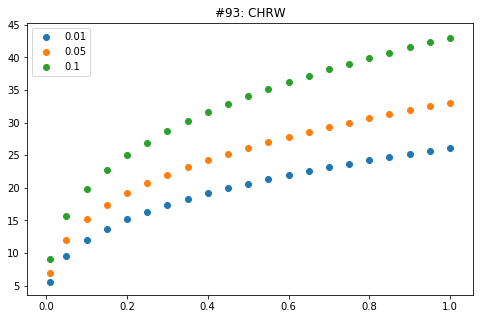

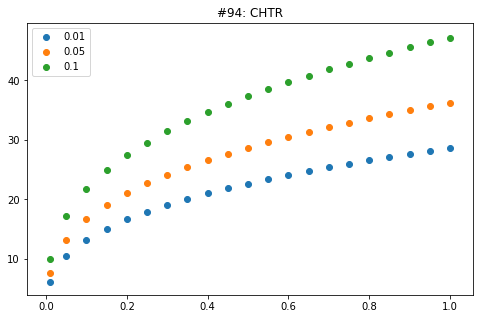

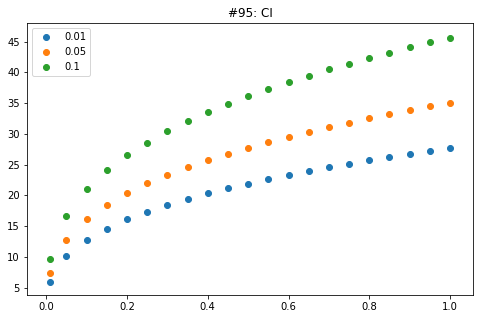

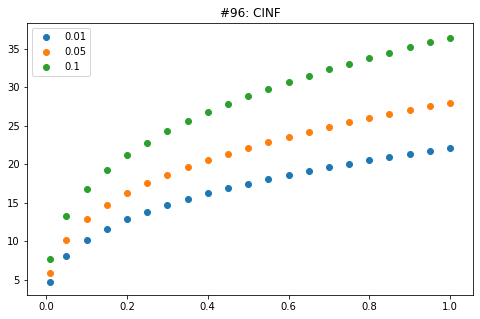

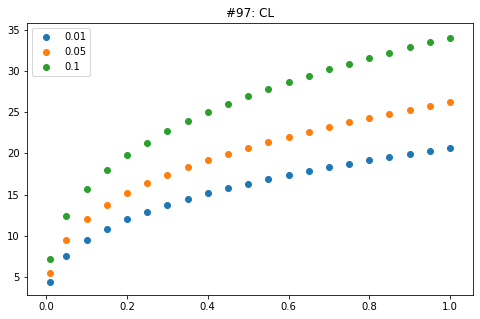

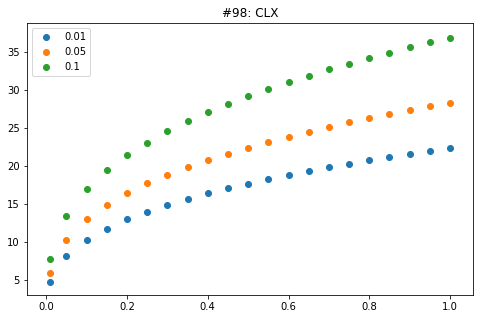

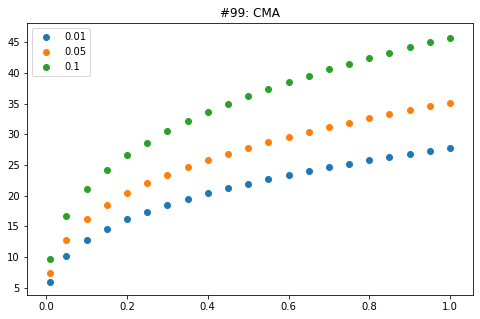

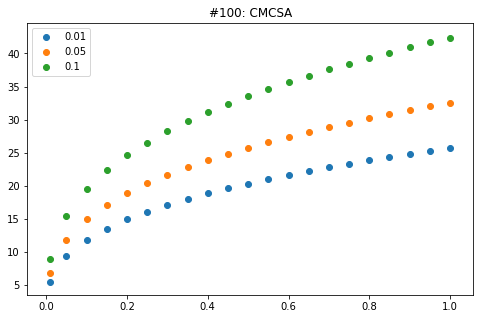

In [36]:
for k in range(50):
    adv_i = adv[k]
    price_i = price[k]
    vol_i = indv_vol[k]

    shares = adv_i*size
    trade_value = shares*price_i
    istar_i = a1*((size)**a2)*(vol_i**a3)

    pov_series = np.array([0.01, 0.05, 0.1])
    MI_size_pov = np.ones((21,3))
    for i in range(21):
        for j in range(3):
            MI_size_pov[i][j] = istar_i[i]*(b1*(pov_series[j]**a4)+(1-b1))
    MI_size_pov = pd.DataFrame(MI_size_pov, columns = pov_series, index = size)
    
    fig = plt.figure(figsize = (8,5))
    plt.scatter(size, MI_size_pov[0.01])
    plt.scatter(size, MI_size_pov[0.05])
    plt.scatter(size, MI_size_pov[0.1])
    plt.title(f'#{list(sel)[k]+1}: {tick_sel[k]}')
    plt.legend(pov_series)
    plt.show()

## 2) Pre-Trade Analysis

### Get the MI and TR for each stock
### Compute real cost; Get the PDF and CDF data for each stock
### Plot the PDF and CDF curve for each stock

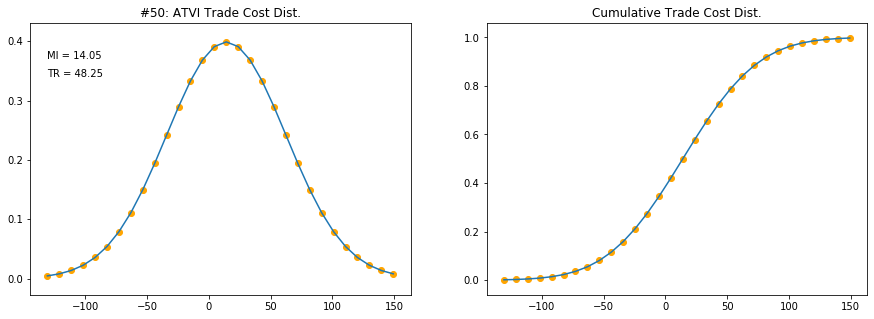

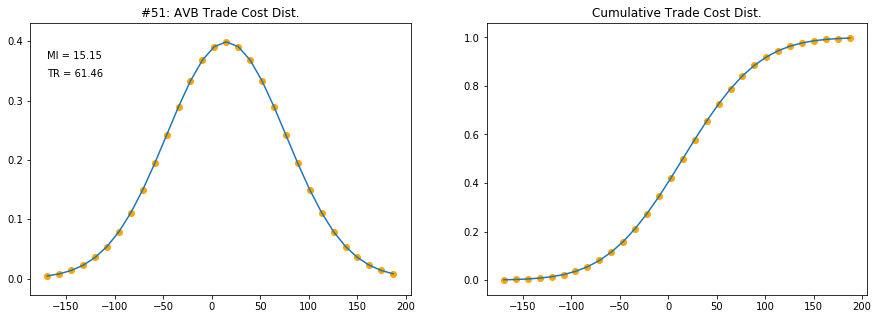

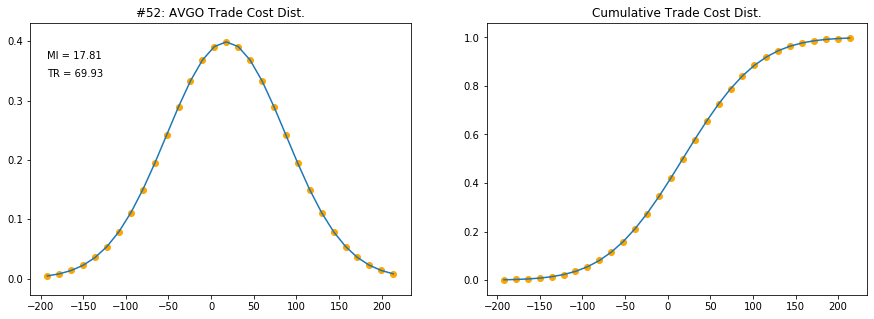

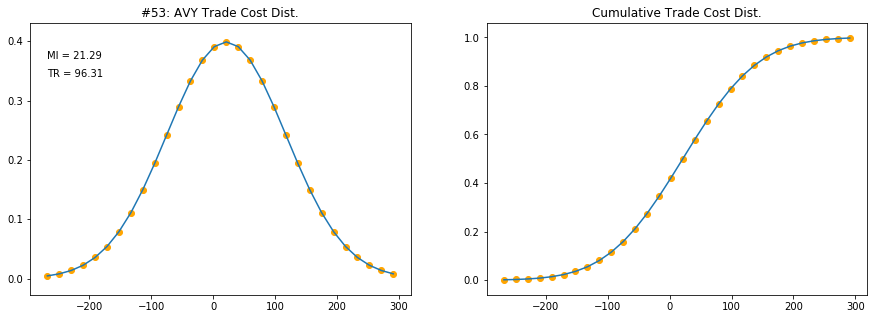

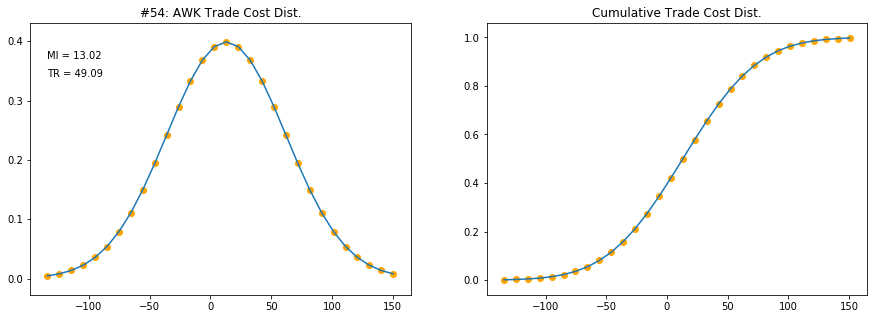

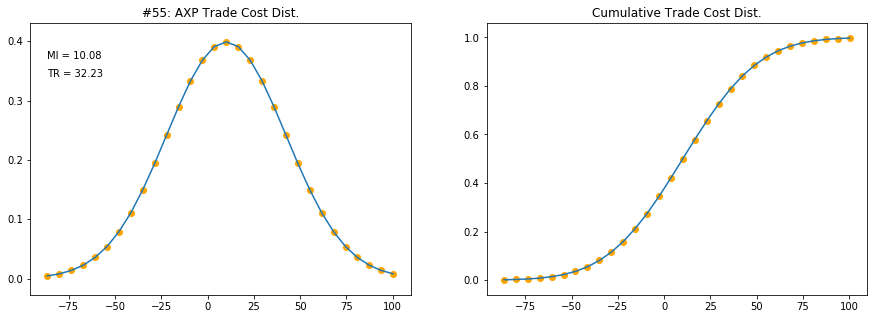

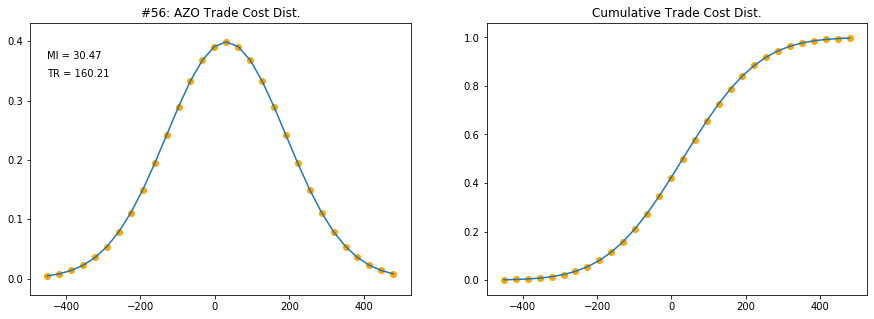

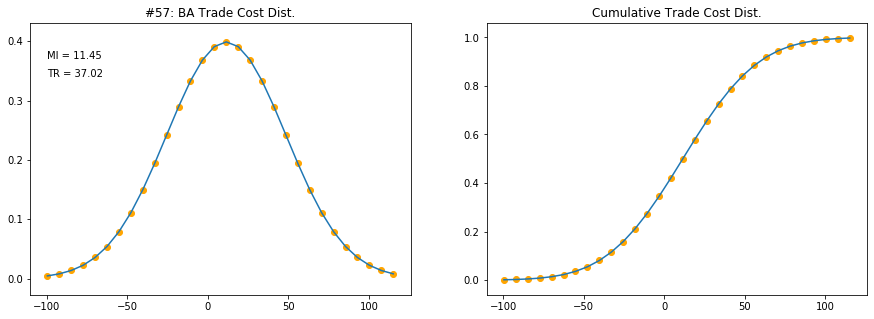

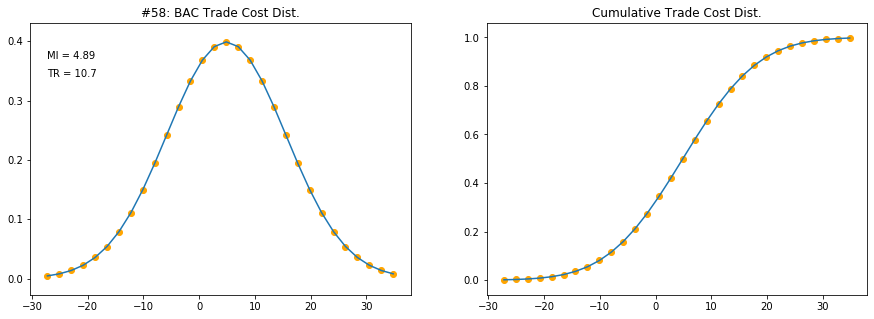

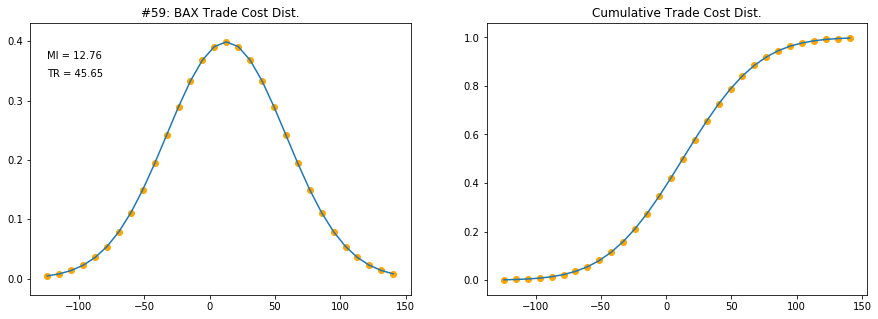

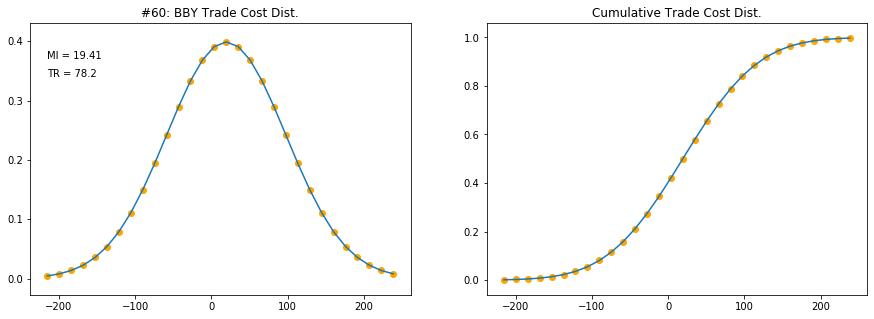

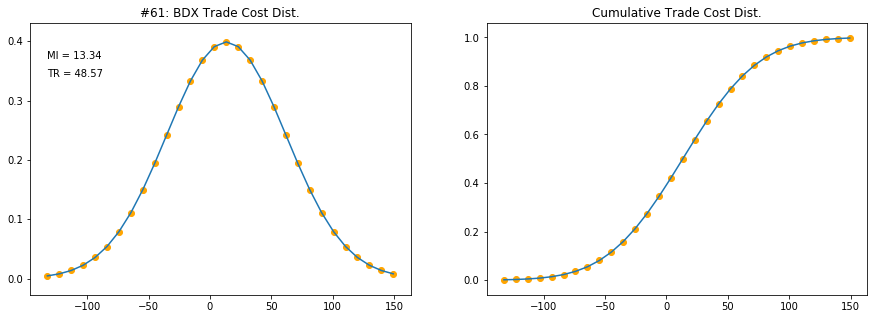

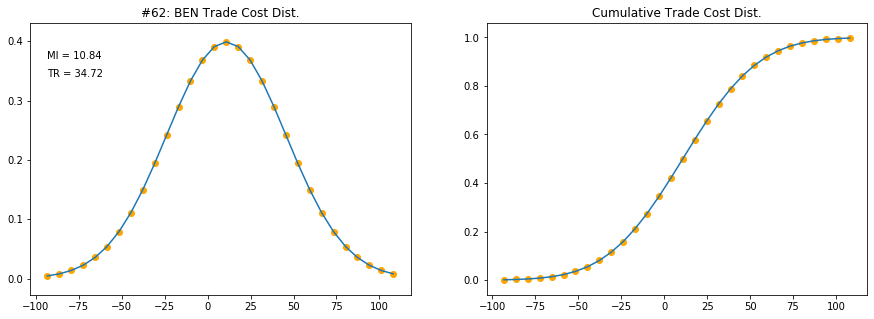

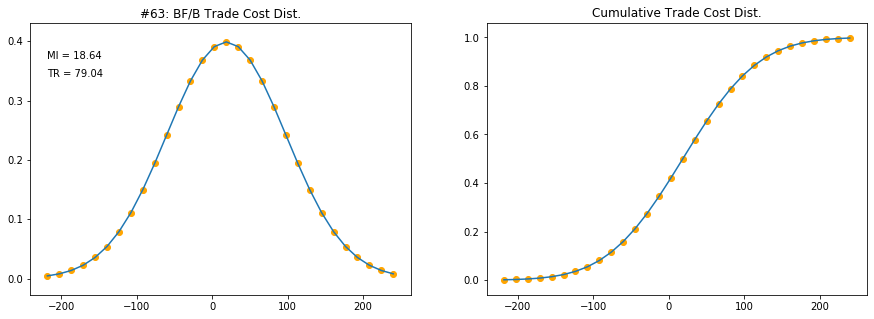

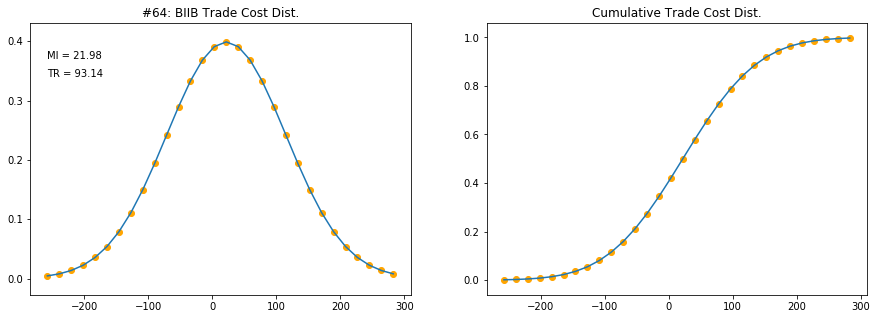

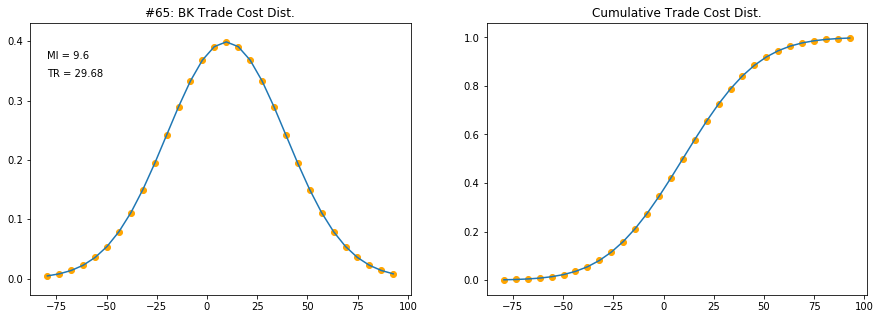

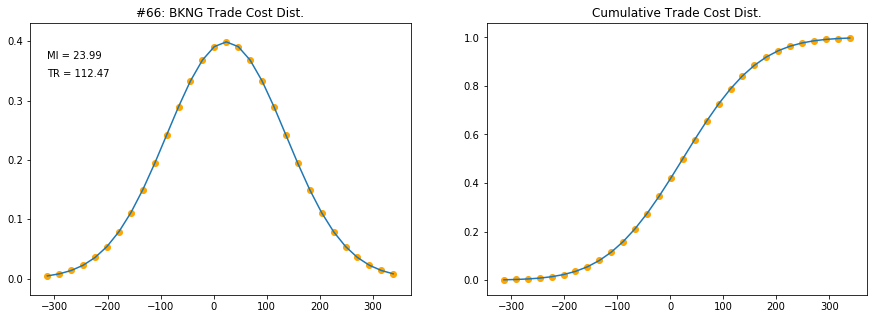

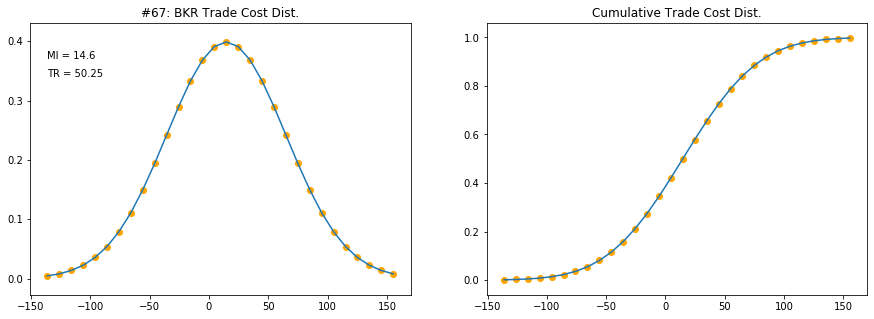

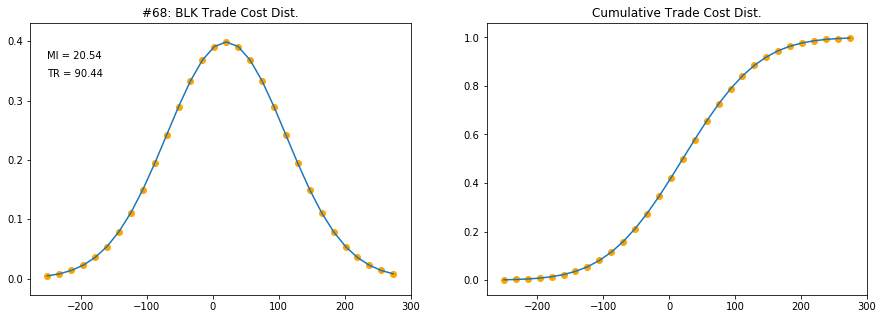

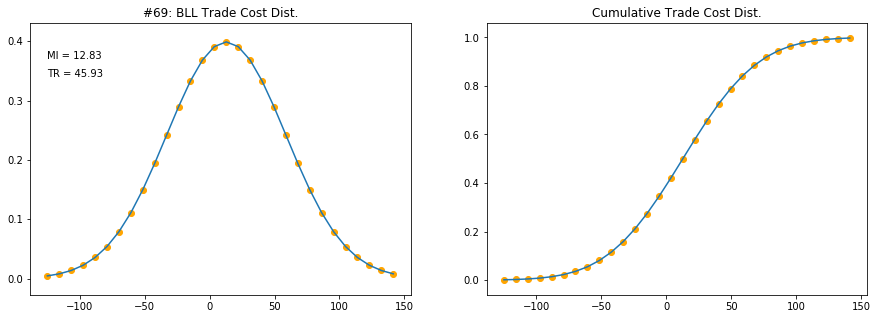

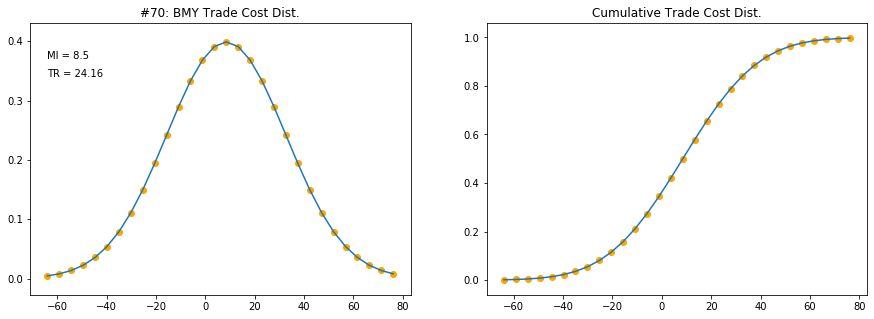

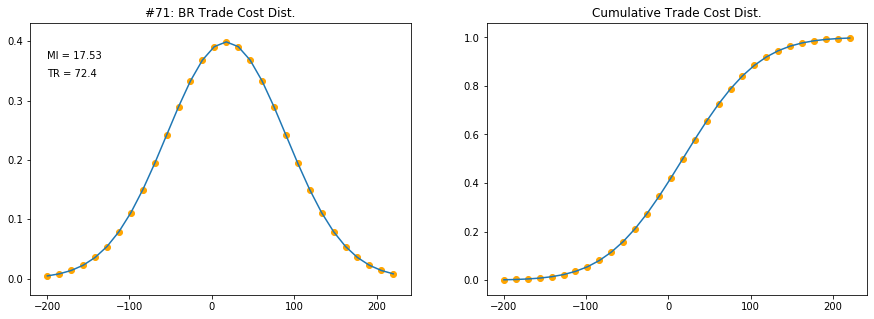

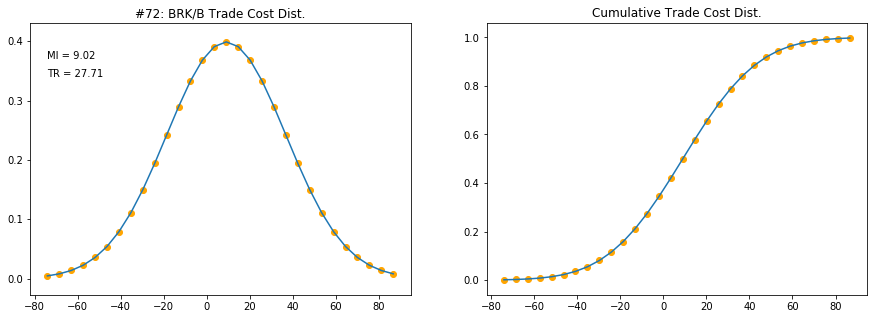

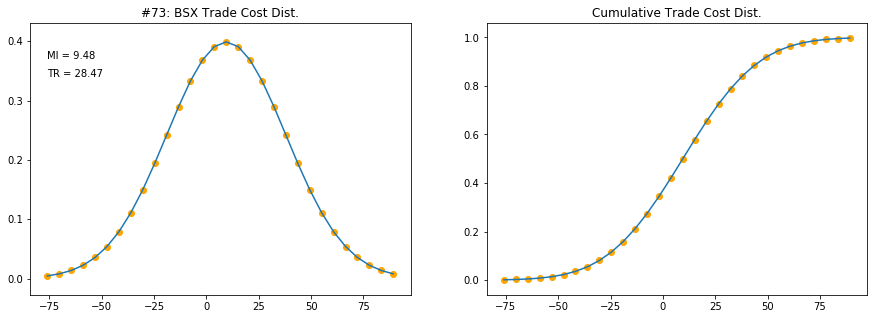

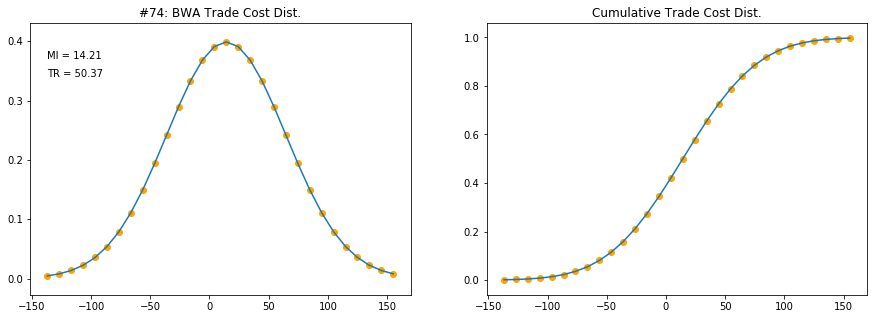

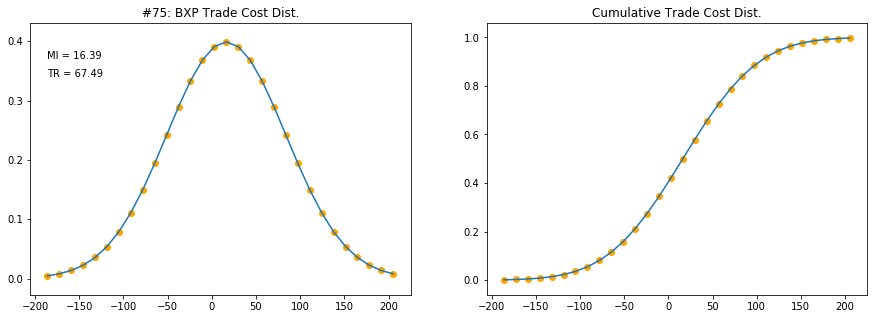

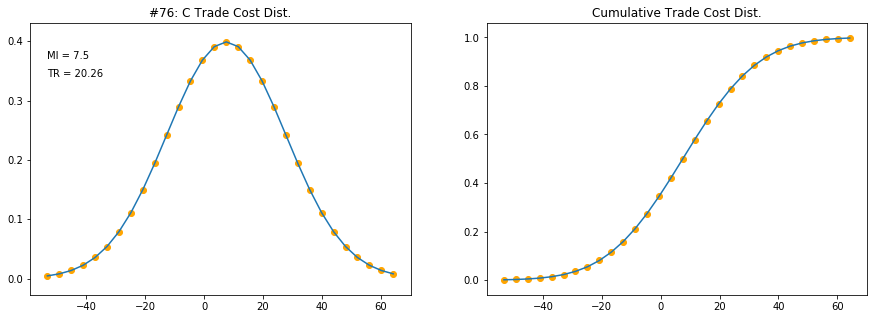

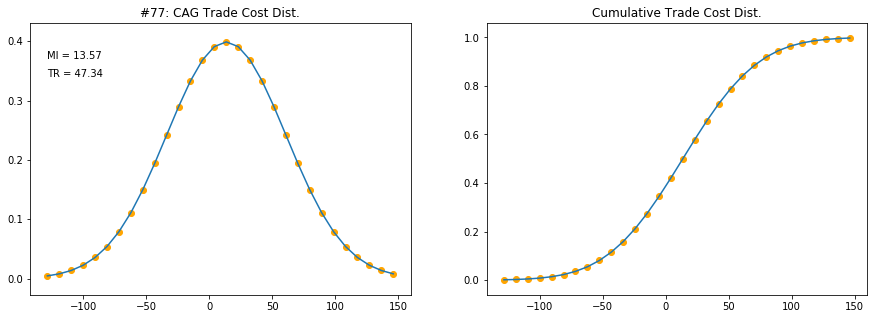

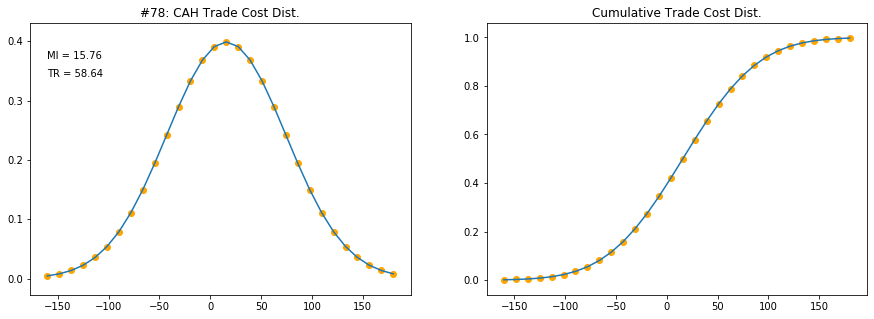

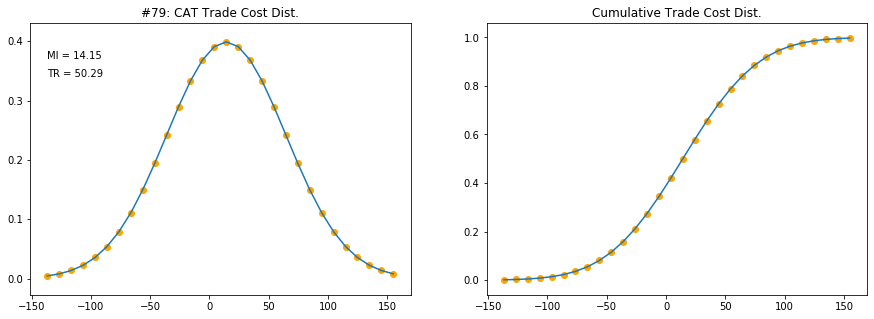

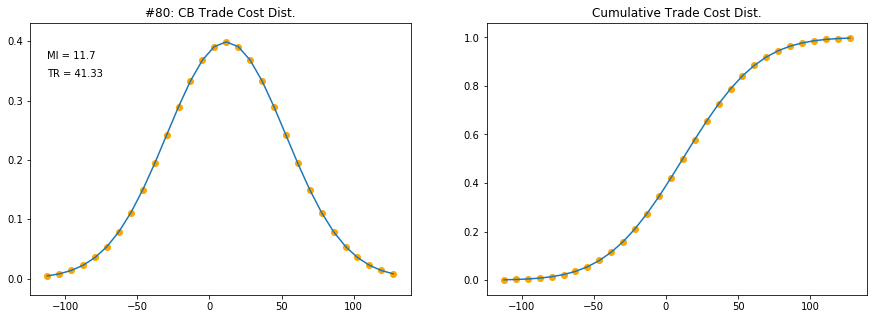

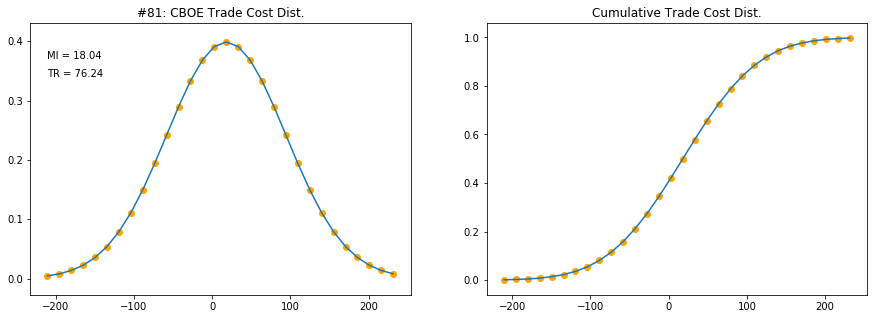

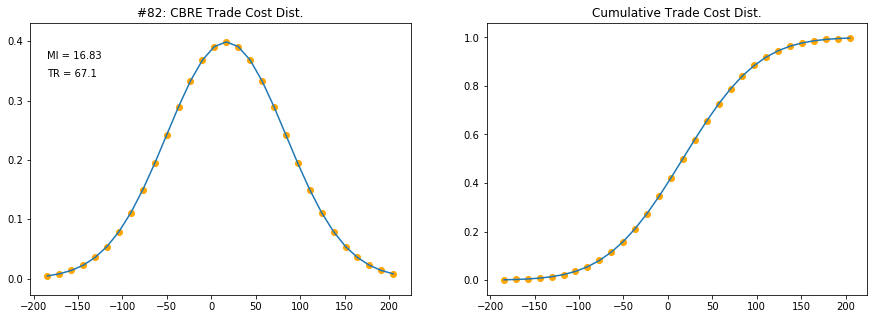

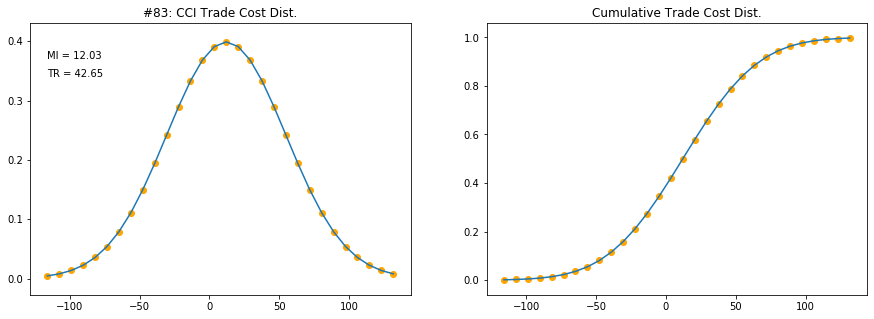

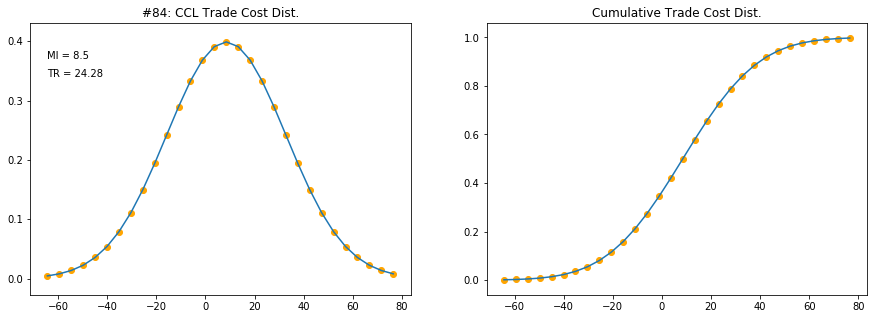

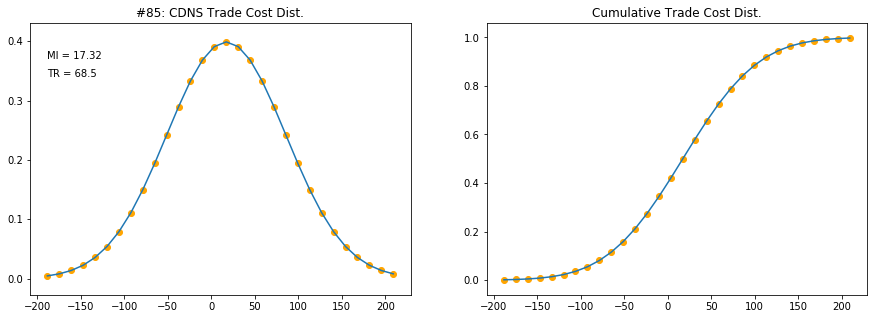

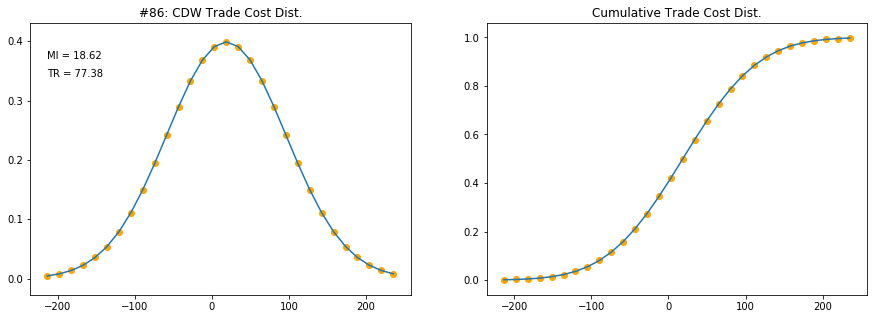

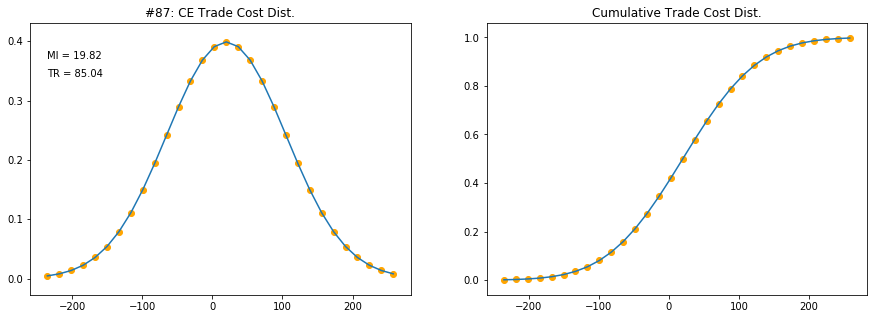

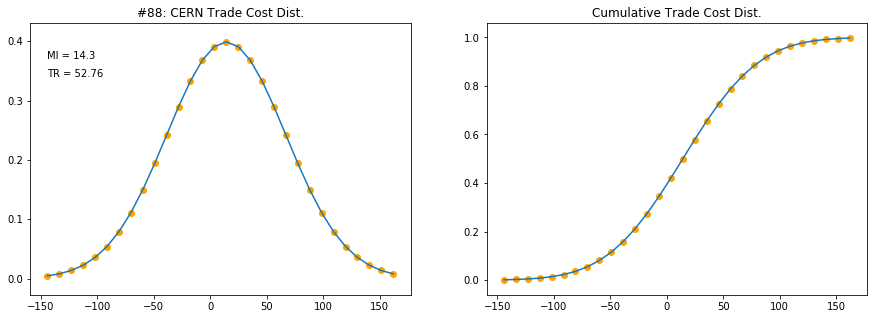

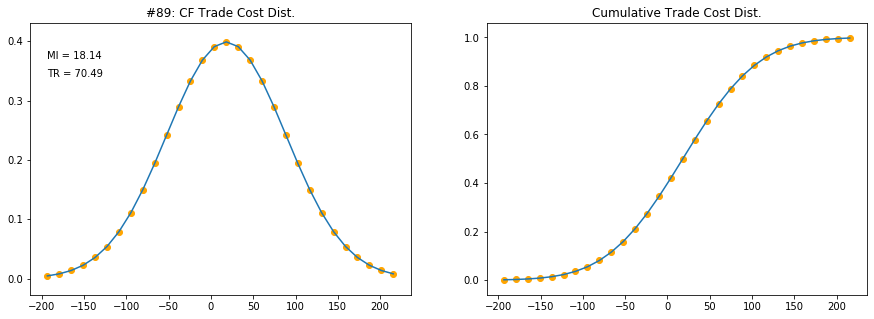

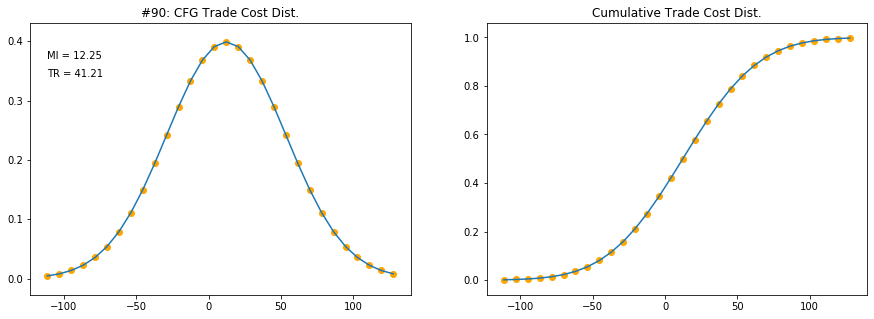

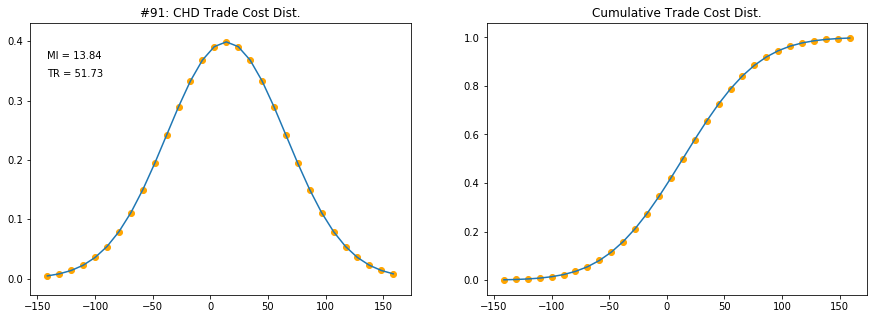

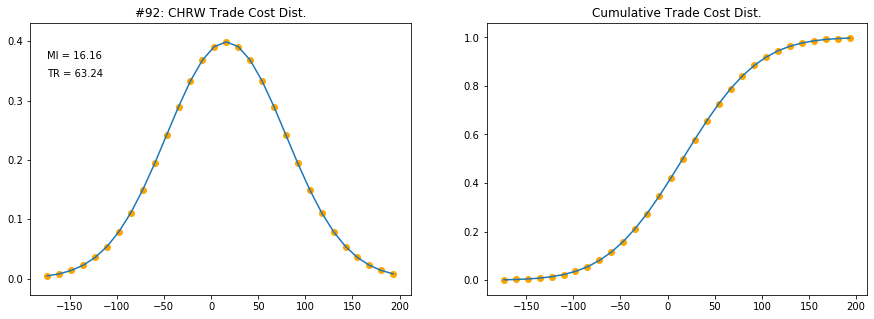

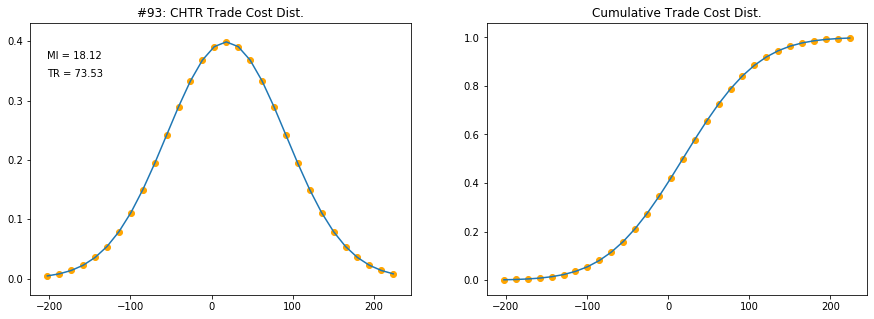

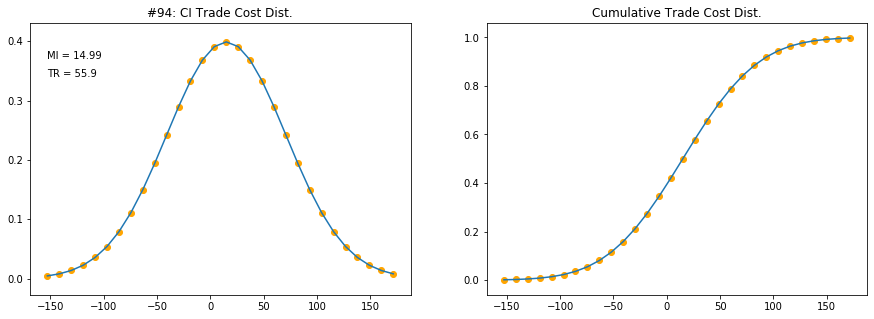

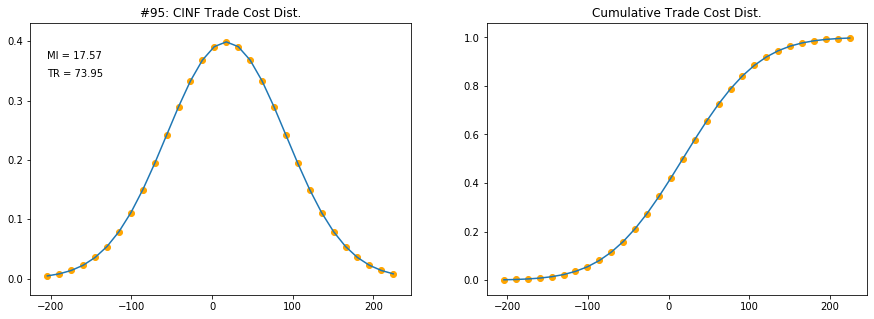

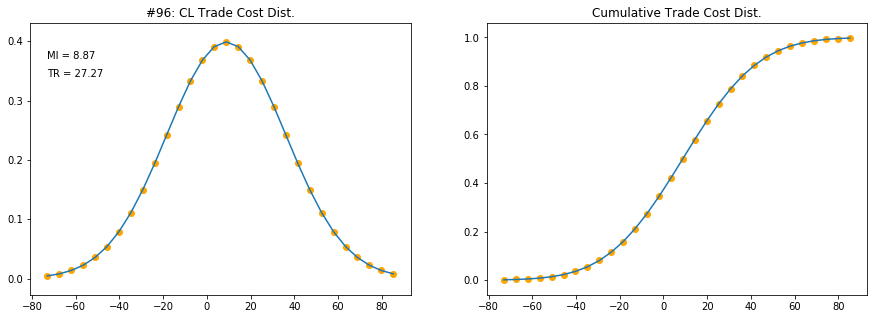

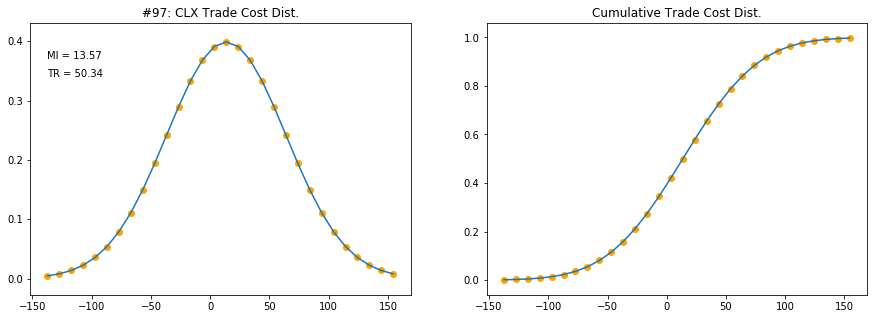

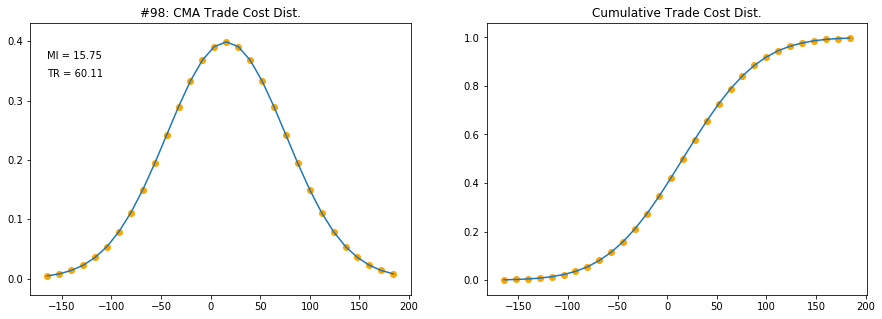

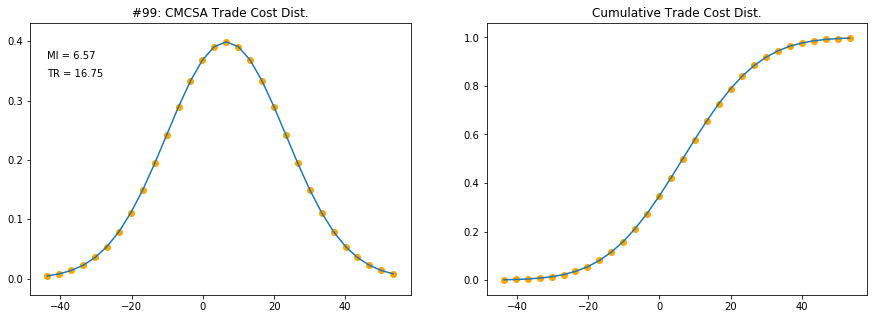

In [37]:
pov = 0.1
shares = 100000

for i in range(50):
    adv_i = adv[i]
    size_i = shares/adv_i
    vol_i = indv_vol[i]
    MI = a1*(size_i**a2)*(vol_i**a3)*(b1*(pov**a4)+(1-b1))
    TR = vol_i*((1/250*1/3*size_i*(1-pov)/pov)**0.5)*10000
    Time = size_i*(1-pov)/pov
    Time

    cost = []
    pdf = []
    cdf = []
    for k in np.arange(-3, 3, 0.2):
        cost_k = MI + k*TR
        cost.append(cost_k)
        pdf.append(norm.pdf(k))
        cdf.append(norm.cdf(k))
    fig = plt.figure(figsize = (15,5))
    fig.add_subplot(121)
    plt.scatter(cost, pdf, color = 'orange')
    plt.plot(cost, pdf)
    plt.title(f'#{list(sel)[i]}: {tick_sel[i]} Trade Cost Dist.')
    plt.annotate(f'MI = {round(MI,2)}', (cost[0],0.37))
    plt.annotate(f'TR = {round(TR,2)}', (cost[0],0.34))
    fig.add_subplot(122)
    plt.scatter(cost, cdf, color = 'orange')
    plt.plot(cost, cdf)
    plt.title('Cumulative Trade Cost Dist.')
    plt.show()
